# <span style="color:blue">Анализ влияния различных факторов на<br />отметки учеников<br />за государственный экзамен по математике (15-22 года)</span>

## Основные цели и задачи проекта

Основная задача:<br />
отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,
чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

- Провести первичный анализ и очистку данных от пустых или бессмысленных значений;
- Устранить выбросы в числовых данных;
- Найти числовые переменные, влияющие на оценку за экзамен по математике провести их анализ;
- Найти номинативные переменные, влияющие на оценку за экзамен по математике;
- Сформулировать и подтвердить либо опровергнуть набор гипотез о влиянии<br/>
  тех или иных факторов на экзаменационные оценки по математике;
- Предложить итоговый набор ограниченный переменных из очищенного набора данных;
- Сделать сводку итоговых выводов по проведённому разведовательному анализу данных.
- Протестировать базовые модели машинного обучения

# Описание датасета

Переменные, которые содержит датасет:
1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике


## Загрузка кода для работы с данными

### Импорт библиотек и функций для анализа

In [1]:
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import iqr

from datetime import datetime
from typing import Callable
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import linear_model
from sklearn import tree
from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

#### Подпрограммы для рисования графиков

In [2]:
def get_boxplot(data: pd.DataFrame, column_x, column_y):
    """Рисование диаграммы boxplot для
    колонки column_x по оси абсцисс и колонки column_y по оси ординат.

    Parameters:
        data - общий набор данных, в колонке column которого найдены выбросы
        column_x - колонка с данными, откладываемыми по оси абсцисс
        column_y - колонка с данными, откладываемыми по оси ординат
    
    Returns:
        See description.
    """
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(
        x=column_x, y=column_y.name, 
        data=data.loc[data.loc[:, column_x].isin(data.loc[:, column_x].value_counts().index[:10])],
        ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_x)
    plt.show()

### Подпрограммы для нахождения квартилей и устранения выбросов для числовых данных

In [3]:
def q1_value(column: pd.Series):
    """Вычисление первого квартиля в заданной колонке.

    Parameters:
        column - колонка для нахождения квартиля
    
    Returns:
        See description.
    """
    return column.quantile(q=0.25)


def q3_value(column: pd.Series):
    """Вычисление третьего квартиля в заданной колонке.

    Parameters:
        column - колонка для нахождения квартиля
    
    Returns:
        See description.
    """
    return column.quantile(q=0.75)


def q2_value(column: pd.Series):
    """Вычисление медианы в заданной колонке.

    Parameters:
        column - колонка для нахождения медианы
    
    Returns:
        See description.
    """
    return column.quantile(q=0.5)


def iqr_value(column: pd.Series):
    """Вычисление интерквартильного размаха.

    Parameters:
        column - колонка для нахождения интерквартильного размаха
    
    Returns:
        See description.
    """
    return q3_value(column) - q1_value(column)


def outlier_borders(column: pd.Series):
    """Вычисление границ для нахождения выбросов.

    Parameters:
        column - колонка для нахождения границ, за которыми могут быть выбросы
    
    Returns:
        See description.
    """
    q1 = q1_value(column)
    q3 = q3_value(column)
    iqr = iqr_value(column)
    print(f"q1 = {q1}, q3 = {q3}, borders = {(q1 - 1.5 * iqr, q3 + 1.5 * iqr)}")
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)


def outliers_datacolumn(column: pd.Series):
    """Вычисление выбросов.

    Parameters:
        column - колонка для нахождения выбросов
    
    Returns:
        See description.
    """
    borders = outlier_borders(column)
    return column[(column < borders[0]) | (column > borders[1])]


def get_outliers(outliers: pd.Series, column: pd.Series, data: pd.DataFrame):
    """Получение полной таблицы записей с выбросами в заданной колонке.

    Parameters:
        outliers - объект pd.Series, содержащий индексы и значения выбросов в колонке column
        column - колонка, содержащая выбросы
        data - общий набор данных, в колонке column которого найдены выбросы
    
    Returns:
        See description.
    """
    print(f"Выбросы в колонке '{column.name}': {outliers}")
    msg_no_outliers = f"Выбросов в колонке '{column.name}' НЕТ"
    msg_have_outliers = f"Выбросы в колонке '{column.name}' ЕСТЬ: {len(outliers.index)} выброс(а/ов)"
    print(f"{msg_no_outliers if outliers.empty else msg_have_outliers}")
    if not outliers.empty:
        return data[data[column.name].isin(outliers)]
    else:
        return pd.DataFrame()


def drop_outliers(outliers: pd.Series, column: pd.Series, data: pd.DataFrame):
    """Удаление записей из полного набора занных data с выбросами в заданной колонке column.

    Parameters:
        outliers - объект pd.Series, содержащий индексы и значения выбросов в колонке column
        column - колонка, содержащая выбросы
        data - общий набор данных, в колонке column которого найдены выбросы
    
    Returns:
        See description.
    """
    data.drop(data[data[column.name].isin(outliers)].index, inplace=True)

### Подпрограммы для теста Стьюдента

In [4]:
def find_statistical_differences(data: pd.DataFrame, column: str, target_column: str):
    """Осуществляет множественную проверку гипотезы об отсутствии
    статистически значимых различий при рассмотрении различных фиксируемых значений
    номинативной переменной column по отношению к числовой переменной target_column. 

    Parameters:
        data - некоторый набор данных
        column - колонка с номинативными данными,
                 которые могут принадлежать некоторому набору уникальных строковых значений.
        target_column - колонка с числовыми показателями (рейтинг, отметка за экзамен),
                        для значений из которой ищутся заметные статистические отличия
                        при сопоставлении этого численного показател для разных значений
                        из номинативной колонки column
    
    Returns:
        See description.
    """
    # Предполагаем, что нам хватит первых десыти самых частых значений из номинативной переменной column.
    # В случае с набором данных из этого проекта это всегда выполняется (во всех таких колонках значений меньше 10-ти).
    columns = data.loc[:, column].value_counts().index[:10]

    # Образуем все возможные комбинации по два из номинативных значений колонки column
    combinations_all = list(combinations(columns, 2))

    # Делаем тест Стьюдента множество раз по числу комбинаций значений из колонки column
    for combination in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == combination[0], target_column],
                     data.loc[data.loc[:, column] == combination[1], target_column]).pvalue \
                     <= 0.05/len(combinations_all): # Учёт поправки Бонферони (при множественном тестировании гипотезы некоторое число раз - число комбинаций значений колонки)
            print(f"\u2611 Найдены статистически значимые различия для номинативных данных (различных значений) колонки \"{column}\" по отношению к значениям в колонке \"{target_column}\"")
            found_differences = True
            break
    else:
        print(f"\u2612 Статистически значимых различий для номинативных данных (различных значений) колонки \"{column}\" по отношению к значениям в колонке \"{target_column}\" НЕ НАЙДЕНО.")


### Настройка библиотеки для работы с данными

In [5]:
pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', None)

## Загрузка сырых данных

### Загрузка сырых данных из файла

In [6]:
students_raw = pd.read_csv('stud_math.csv')

### Отображение первых нескольких строк сырых данных

In [7]:
students_raw.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Сводная информация о загруженных данных

In [8]:
students_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

На первый взгляд, в датасете 13 числовых столбцов:

 - age 395 non-null int64
 - Medu 392 non-null float64
 - Fedu 371 non-null float64
 - traveltime 367 non-null float64
 - studytime 388 non-null float64
 - failures 373 non-null float64
 - studytime, granular 388 non-null float64
 - famrel 368 non-null float64
 - freetime 384 non-null float64
 - goout 387 non-null float64
 - health 380 non-null float64
 - absences 383 non-null float64
 - score 389 non-null float64
 
Эти столбцы числовые, но по факту только 2 из них реально числовые признаки: age и absences. score - целевая переменная. 

### Осмотр данных на пропуски

In [9]:
# вот так виднее сколько пропусков для каждого признака
students_raw.isnull().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

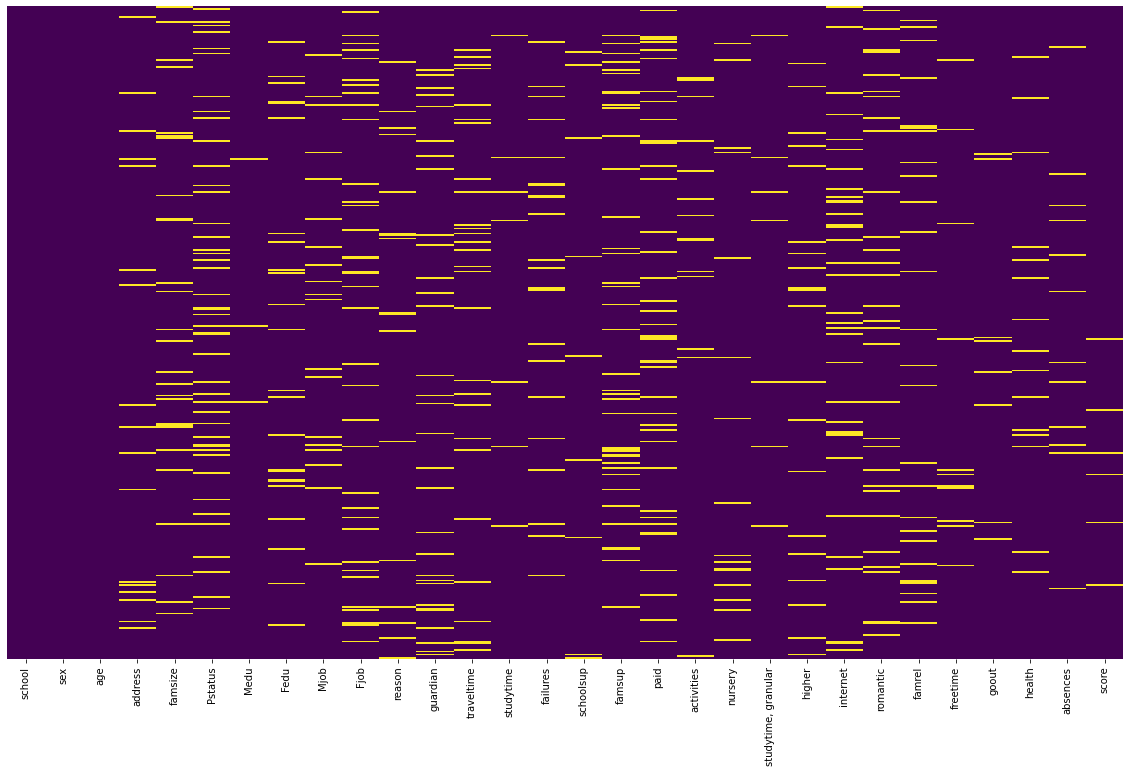

In [10]:
# так еще лучше видно, где пропуски
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    students_raw.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Видно, что только 3 первых признака school, sex, age без пропусков, все остальные - с пропусками. 

Взглянем, есть ли очевилные различия между 10% студентов без оценки оли с самой низкой оценкой от 10% студентов с самыми высокими оценками:

## Двоечники - нижние 10% score

In [11]:
students_raw.sort_values('score', ascending=True, na_position='first').head(40)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
201,GP,F,16,U,GT3,T,2.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,NaN,yes,yes,-6.0,yes,no,no,4.0,NaN,3.0,4.0,6.0,NaN
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,course,other,2.0,3.0,0.0,no,yes,yes,no,no,-9.0,yes,yes,yes,4.0,4.0,4.0,3.0,0.0,NaN
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN
283,GP,F,18,U,GT3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,yes,NaN,no,yes,yes,-6.0,yes,yes,no,5.0,NaN,4.0,4.0,4.0,NaN
312,GP,M,19,U,GT3,T,1.0,2.0,other,services,course,other,1.0,2.0,1.0,no,no,no,no,no,-6.0,yes,yes,no,4.0,5.0,NaN,4.0,3.0,NaN
350,MS,M,19,NaN,GT3,T,1.0,1.0,other,services,home,other,3.0,2.0,3.0,no,no,no,no,NaN,-6.0,yes,yes,no,5.0,4.0,4.0,2.0,8.0,NaN
296,GP,F,19,U,GT3,T,4.0,4.0,health,other,reputation,other,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,2.0,3.0,4.0,2.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
170,GP,M,16,U,GT3,T,3.0,4.0,other,other,course,father,3.0,1.0,NaN,no,yes,no,yes,no,-3.0,NaN,yes,no,3.0,4.0,5.0,2.0,0.0,0.0
333,GP,F,18,U,LE3,NaN,2.0,2.0,other,other,home,other,1.0,2.0,0.0,no,no,no,yes,no,-6.0,yes,NaN,yes,4.0,3.0,3.0,2.0,0.0,0.0


## Отличники (верхние 10% score)

In [12]:
students_raw.sort_values('score', ascending=False, na_position='last').head(40)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
374,MS,F,18,R,LE3,T,4.0,NaN,other,NaN,reputation,mother,2.0,3.0,0.0,no,no,no,no,yes,-9.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,95.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
113,GP,M,15,U,LE3,T,4.0,2.0,teacher,other,course,mother,1.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,yes,no,3.0,5.0,2.0,3.0,10.0,95.0
110,GP,M,15,U,LE3,A,4.0,4.0,teacher,teacher,course,mother,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,NaN,no,5.0,5.0,3.0,4.0,6.0,95.0
286,GP,F,18,U,GT3,T,2.0,NaN,at_home,at_home,other,mother,1.0,3.0,0.0,no,yes,yes,no,yes,-9.0,yes,yes,no,4.0,3.0,3.0,2.0,5.0,95.0
245,GP,M,16,U,GT3,NaN,2.0,1.0,other,other,course,mother,3.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,yes,no,4.0,3.0,3.0,4.0,6.0,90.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
306,GP,M,20,U,GT3,A,3.0,2.0,services,other,course,other,1.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,no,no,5.0,5.0,3.0,5.0,0.0,90.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0


 Можем сказать на данном этапе, что датасет состоит из данных о 395 учениках, в датасете 30 колонок, 13 из которых числовые ( из них истинно числовые - 2, остальные признаки - категориальные, закодированные в числа ) и 17 - строковые. Во всех столбцах, кроме school, sex, age присутствуют пустые значения, однако их не больше 50. Нужно будет проверить, можно ли заполнить пропуски, есть ли выбросы. Потом надо оценить взаимозависимость каждого признака с результатом (score) и выбрать признаки для модели. 
 
 На первый взгляд, отличники мало отличаются от двоечников. Проанализируем каждый признак.

# Первичный анализ данных в столбцах

## Первичная обработка данных

## school — аббревиатура школы, в которой учится ученик

In [13]:
school_value_counts = pd.DataFrame(students_raw.school.value_counts())
display(school_value_counts)

,school
GP,349
MS,46


<AxesSubplot:xlabel='school', ylabel='score'>

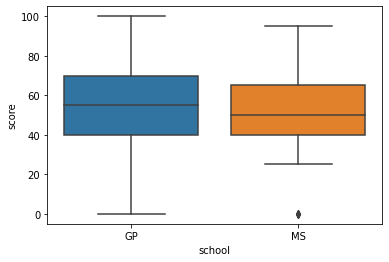

In [14]:
sns.boxplot(y='score', x='school', data=students_raw)

In [15]:
school_MS_count = school_value_counts.school[school_value_counts.school.index == 'MS'].iloc[0]
school_GP_count = school_value_counts.school[school_value_counts.school.index == 'GP'].iloc[0]

print(f"N(MS)/N(GP) * 100% = {round((school_MS_count / school_GP_count) * 100, 1)}%")

N(MS)/N(GP) * 100% = 13.2%


## sex — пол ученика ('F' - женский, 'M' - мужской)

In [16]:
sex_value_counts = pd.DataFrame(students_raw.sex.value_counts())
display(sex_value_counts)

,sex
F,208
M,187


In [17]:
students_raw['sex'].isnull().sum()

0

<AxesSubplot:xlabel='sex', ylabel='score'>

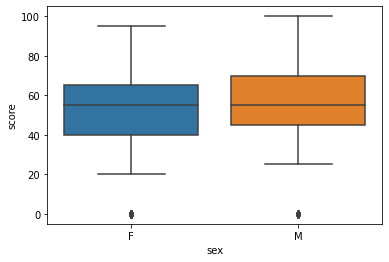

In [18]:
sns.boxplot(y='score', x='sex', data=students_raw)

Количество учеников примерно одинаково по полам в данном наборе. Признак категориальный, пропусков и ошибок нет.

## age — возраст ученика (от 15 до 22)

<AxesSubplot:>

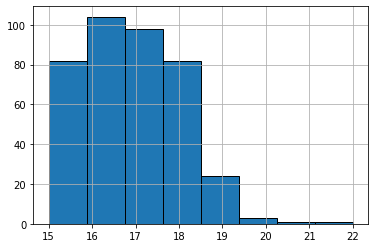

In [19]:
# Этот столбец числовой и без пропусков. Поэтому посмотрим на его распределение:
students_raw.age.hist(bins=8)

In [20]:
students_raw.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

<AxesSubplot:xlabel='age', ylabel='score'>

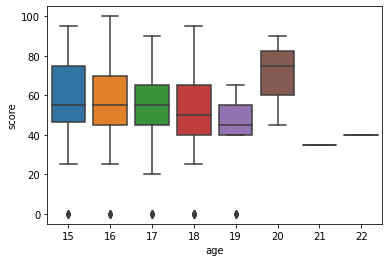

In [21]:
sns.boxplot(y='score', x='age', data=students_raw)

Попробуем отфильтровать выбросы и воспользуемся формулой интерквартильного расстояния. Выбросом считаются такие значения, которые лежат вне рамок [Q1 -1.5IQR : Q3+1.5IQR], где IQR = percentile(75) - percentile(25). Сначала посмотрим на боксплот:

<AxesSubplot:xlabel='age'>

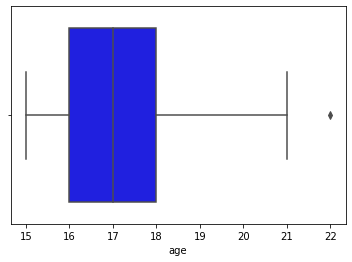

In [22]:
# видно, что, похоже, выбросы есть.
sns.boxplot(students_raw.age, color='blue')

In [23]:
outliers = outliers_datacolumn(students_raw.age)
outlier_data = get_outliers(outliers, students_raw['age'], students_raw)
if not outlier_data.empty:
    display(outlier_data)

q1 = 16.0, q3 = 18.0, borders = (13.0, 21.0)
Выбросы в колонке 'age': 247    22
Name: age, dtype: int64
Выбросы в колонке 'age' ЕСТЬ: 1 выброс(а/ов)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,-3.0,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


Удалим единственный выброс, соответствующий возрасту ученика в 22 года.

In [24]:
print(f"""Общее количество записей до удаления выбросов по возрасту студентов: {len(students_raw)}""")
drop_outliers(outliers, students_raw['age'], students_raw)
print(f"""Общее количество записей после удаления выбросов по возрасту студентов: {len(students_raw)}""")

Общее количество записей до удаления выбросов по возрасту студентов: 395
Общее количество записей после удаления выбросов по возрасту студентов: 394


<AxesSubplot:xlabel='age'>

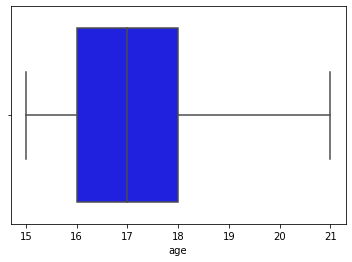

In [25]:
# теперь выбросов нет:
sns.boxplot(students_raw.age, color='blue')

In [26]:
# проверяем значения
students_raw.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
21      1
Name: age, dtype: int64

In [27]:
# проверяем значения
(students_raw.age.value_counts(normalize=True) * 100).round(2)

16    26.40
17    24.87
18    20.81
15    20.81
19     6.09
20     0.76
21     0.25
Name: age, dtype: float64

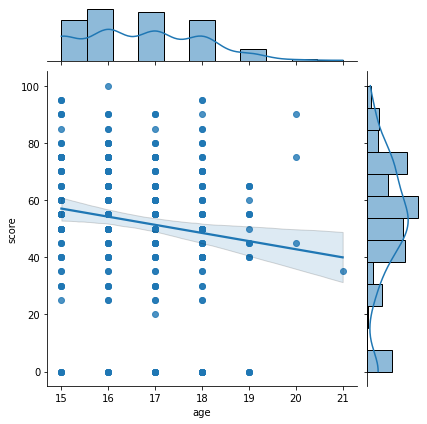

In [28]:
# исследуем зависимость результата от признака age:
sns.jointplot(x='age', y='score', data=students_raw, kind='reg')

__Вывод:__ в колонке age не было пропусков, но был 1 выброс - 22 года, мы нашли этот выброс с помощью boxplot и формулы интерквартильного расстояния, строку с выбросом удалили. Примерно по одной четверти учащихся в возрасте 16 и 17 лет соответственно, примерно по одной пятой - в возрасте 18 и 15 лет. Учащиеся с возрастом 20 лет и 21 год составляют менее одного процента совокупно. Из регрессии на графике видно, что есть обратная зависимость между возратом и результатом экзамена.

## address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [29]:
# выясним, есть ли пропуски:
students_raw.address.value_counts(dropna=False, normalize=True)

U      0.746193
R      0.210660
NaN    0.043147
Name: address, dtype: float64

<AxesSubplot:xlabel='address', ylabel='score'>

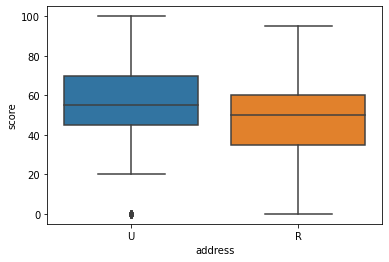

In [30]:
sns.boxplot(y='score', x='address', data=students_raw)

Признак категориальный, 2 уникальных значения, ошибок нет, 4% пропусков. Заполняю пропуски самым частым значением. Сельские студенты сдают тест похуже.

In [31]:
# сделаем замену пустых значений типа адреса на самое часто встречающееся значение - U
students_raw['address'].fillna('U', inplace=True)

In [32]:
# проверяем
students_raw.address.unique()

array(['U', 'R'], dtype=object)

## famsize — размер семьи('LE3' <= 3, 'GT3' >3)

In [33]:
students_raw.famsize.value_counts(dropna=False, normalize=True)

GT3    0.659898
LE3    0.271574
NaN    0.068528
Name: famsize, dtype: float64

In [34]:
students_raw.famsize.mode()[0]

'GT3'

Признак категориальный, ошибок нет, 7% пропусков. Заполняем пропуски модой GT3.

In [35]:
students_raw.famsize.fillna(students_raw.famsize.mode()[0], inplace=True)
students_raw.famsize.unique()

array(['GT3', 'LE3'], dtype=object)

<AxesSubplot:xlabel='famsize', ylabel='score'>

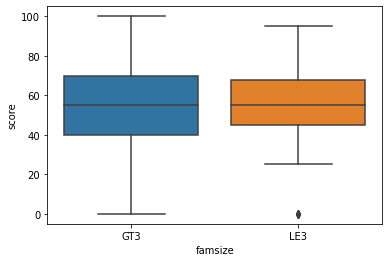

In [36]:
sns.boxplot(y='score', x='famsize', data=students_raw)

## Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [37]:
students_raw.Pstatus.value_counts(dropna=False)

T      313
NaN     45
A       36
Name: Pstatus, dtype: int64

Признак категориальный, 45 пропусков. Заполняю пропуски значением 'N', так как число их велико, больше 10%.

In [38]:
students_raw.Pstatus.fillna('N', inplace=True)

In [39]:
students_raw.Pstatus.unique()

array(['A', 'N', 'T'], dtype=object)

<AxesSubplot:xlabel='Pstatus', ylabel='score'>

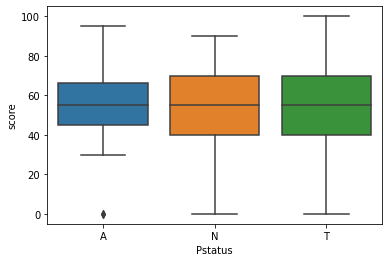

In [40]:
sns.boxplot(y='score', x='Pstatus', data=students_raw)

## Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [41]:
Medu_value_counts = pd.DataFrame(students_raw.Medu.value_counts())
display(Medu_value_counts)

,Medu
4.0,131
2.0,102
3.0,96
1.0,59
0.0,3


In [42]:
# проверяю
students_raw.Medu.unique()

array([ 4.,  1.,  3.,  2., nan,  0.])

<AxesSubplot:>

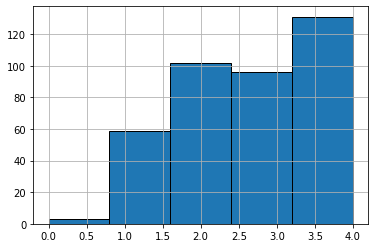

In [43]:
students_raw.Medu.hist(bins=5)

Больше всего по количеству та группа матерей, у которых есть высшее образование.<br />
Затем количество в каждой группе постепенно снижается со снижением уровня образования.

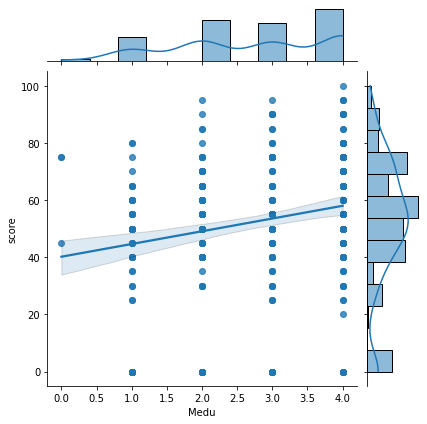

In [44]:
sns.jointplot(y='score', x='Medu', data=students_raw, kind='reg')

<AxesSubplot:xlabel='Medu'>

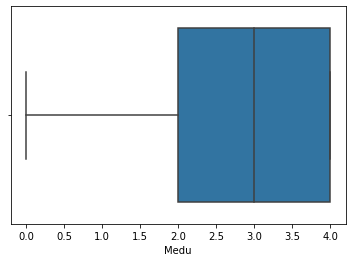

In [45]:
# также проверяем, есть ли выбросы в признаке
sns.boxplot(students_raw.Medu)

__Вывод:__ Признак ординальный, ошибок нет, 3 пропуска. Заполняю пропуски самым частым значением 4. Дети женщин без образования сдают тест с максимальным разбросом оценок.

In [46]:
students_raw.Medu.fillna(4.0, inplace=True)

## Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [47]:
students_raw.Fedu.value_counts(dropna=False)

2.0     106
3.0      96
4.0      88
1.0      77
NaN      24
0.0       2
40.0      1
Name: Fedu, dtype: int64

Считем выброс - 40.0 - следствием опечатки, заменяем на 4.0

In [48]:
students_raw.loc[students_raw.Fedu == 40.0, 'Fedu'] = 4.0

<AxesSubplot:>

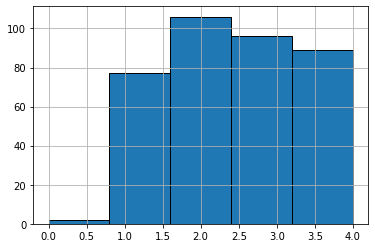

In [49]:
students_raw.Fedu.hist(bins=5)

<AxesSubplot:xlabel='Fedu'>

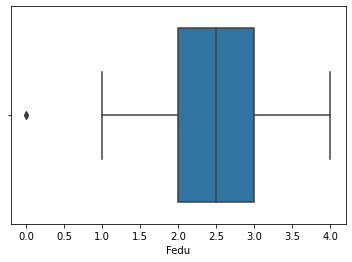

In [50]:
# остались ли выбросы сейчас?
sns.boxplot(students_raw.Fedu)

Выбросы - данные о 2 детях, у которых отцы без образования. Не будем удалять их.

Пропуски. Видим что из 395 нет информации о 24 строках. Всего 5% процентов пропусков. Заменим на самое часто встречающееся значение - 2.

In [51]:
students_raw.Fedu.fillna(students_raw.Fedu.mode()[0], inplace=True)
students_raw.Fedu.unique()

array([4., 1., 2., 3., 0.])

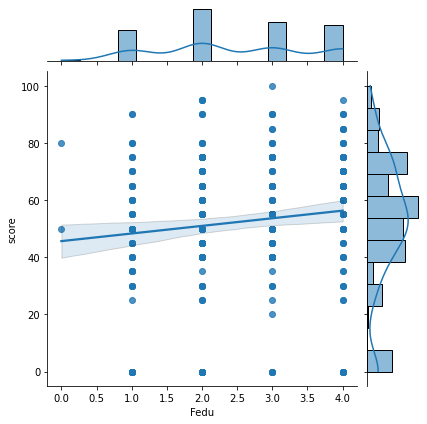

In [52]:
sns.jointplot(y='score', x='Fedu', data=students_raw, kind='reg')

__Вывод:__ Признак ординальный. В колонке Fedu был 1 выброс и были пропуски, которые мы заменили самым часто встречающимся значением.

## Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [53]:
students_raw.Mjob.value_counts(dropna=False)

other       133
services     97
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64

Mjob — уникальных значений 5, других значений нет, значит в данных нет опечаток, но есть пропуски, их меньше 10%, заменим их модой.

In [54]:
students_raw.Mjob.fillna(students_raw.Mjob.mode()[0], inplace=True)
students_raw.Mjob.unique()

array(['at_home', 'health', 'other', 'services', 'teacher'], dtype=object)

<AxesSubplot:xlabel='Mjob', ylabel='score'>

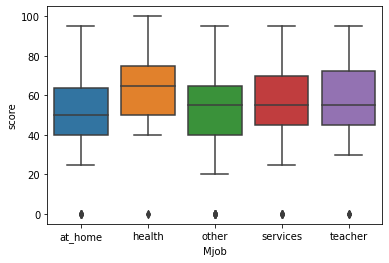

In [55]:
sns.boxplot(y='score', x='Mjob', data=students_raw)

__Вывод:__ в колонке Mjob не было ошибочных данных, но было небольшое количество пропусков, которое мы заменили на самое часто встречающееся значение - other, у больше чем 33% учеников работа матери относится к категории "другая".

## Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [56]:
students_raw.Fjob.value_counts(dropna=False)

other       197
services    101
NaN          36
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

In [57]:
(students_raw.Fjob.value_counts(dropna=False, normalize=True) * 100).round(2)

other       50.00
services    25.63
NaN          9.14
teacher      7.36
at_home      4.06
health       3.81
Name: Fjob, dtype: float64

Ошибок нет, пропусков менее 10%, заменяем их на моду.

In [58]:
students_raw.Fjob.fillna(students_raw.Fjob.mode()[0], inplace=True)
students_raw.Fjob.unique()

array(['teacher', 'other', 'health', 'services', 'at_home'], dtype=object)

<AxesSubplot:>

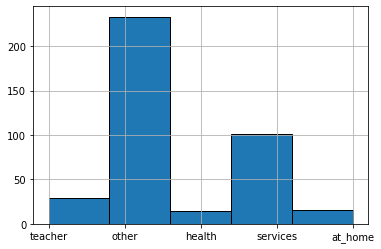

In [59]:
students_raw.Fjob.hist(bins=5)

<AxesSubplot:xlabel='Fjob', ylabel='score'>

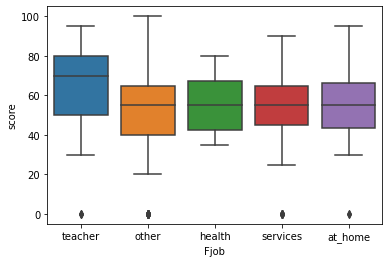

In [60]:
sns.boxplot(y='score', x='Fjob', data=students_raw)

__Вывод:__ в колонке Fjob не было ошибочных данных, но было небольшое количество пропусков, которое мы заменили на самое часто встречающееся значение - other, у почти 50% студентов работа отца какая-то другая.

## reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [61]:
students_raw.reason.value_counts(dropna=False)

course        137
home          104
reputation    103
other          33
NaN            17
Name: reason, dtype: int64

Признак категориальный, ошибок нет, пропусков менее 5%. Заполняем модой - 'course'

In [62]:
students_raw.reason.fillna(students_raw.reason.mode()[0], inplace=True)
students_raw.reason.unique()

array(['course', 'other', 'home', 'reputation'], dtype=object)

<AxesSubplot:xlabel='reason', ylabel='score'>

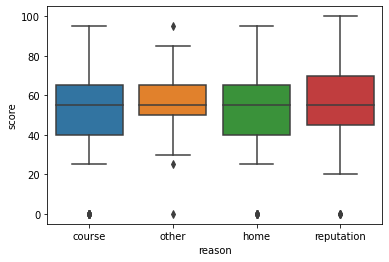

In [63]:
sns.boxplot(y='score', x='reason', data=students_raw)

__Вывод:__ было небольшое количество пропусков, которое мы заменили на самое часто встречающееся значение - course, примерно 36% студентов выбрали школу из-за образовательной программы, но это не привело к лучшим результатам в тесте.

## guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [64]:
students_raw.guardian.value_counts(dropna=False)

mother    249
father     86
NaN        31
other      28
Name: guardian, dtype: int64

guardian — уникальных значений 3, других значений нет, в данных нет опечаток, но есть пропуски - менее 10%.

In [65]:
students_raw.guardian.fillna(students_raw.guardian.mode()[0], inplace=True)
students_raw.guardian.unique()

array(['mother', 'father', 'other'], dtype=object)

<AxesSubplot:xlabel='guardian', ylabel='score'>

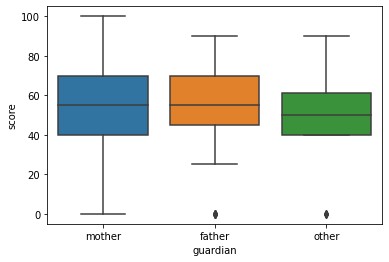

In [66]:
sns.boxplot(y='score', x='guardian', data=students_raw)

__Вывод:__ колонке guardian не было ошибочных данных, но было небольшое количество пропусков, которое мы заменили на самое часто встречающееся значение - mother, у почти 69% студентов опекуном является мать. Если опекун - не отец или мать, оценка студента в среднем похуже.

## traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [67]:
students_raw.traveltime.value_counts(dropna=False)

1.0    241
2.0     96
NaN     28
3.0     22
4.0      7
Name: traveltime, dtype: int64

 traveltime — уникальных значений 4, других значений нет, значит в данных нет опечаток, но есть пропуски - менее 10%

In [68]:
students_raw.traveltime.fillna(students_raw.traveltime.mode()[0], inplace=True)
students_raw.traveltime.unique()

array([2., 1., 3., 4.])

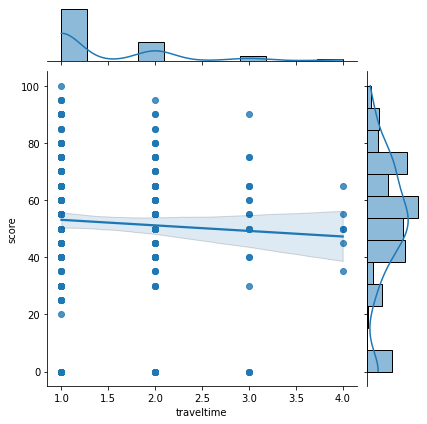

In [69]:
sns.jointplot(y='score', x='traveltime', data=students_raw, kind='reg')

__Вывод:__ traveltime - признак ординальный, 28 пропусков.Заменил на самую частую категорию - 1 <15 мин, почти 66% студентов живут в 15 минутах от школы

## studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [70]:
students_raw.studytime.value_counts(dropna=False)

2.0    194
1.0    102
3.0     64
4.0     27
NaN      7
Name: studytime, dtype: int64

studytime — ошибок заполнения нет, пропусков - 7. Заменяю на моду.

In [71]:
students_raw.studytime.fillna(students_raw.studytime.mode()[0], inplace=True)
students_raw.studytime.unique()

array([2., 3., 1., 4.])

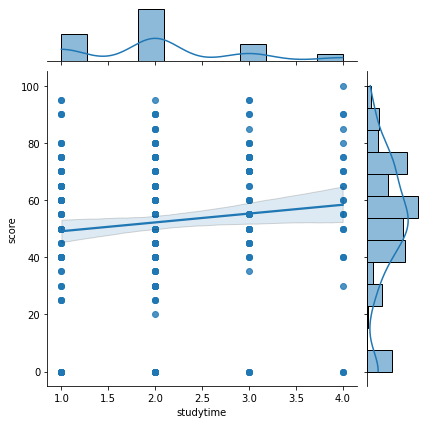

In [72]:
sns.jointplot(y='score', x='studytime', data=students_raw, kind='reg')

__Вывод:__ признак ординальный, 7 пропусков.Заменил на моду - 2. 50% студентов тратят на учебу от 2 до 5 часов.

## failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4)

In [73]:
students_raw.failures.value_counts(dropna=False)

0.0    293
1.0     49
NaN     22
2.0     16
3.0     14
Name: failures, dtype: int64

In [74]:
students_raw.failures.fillna(students_raw.failures.mode()[0], inplace=True)
students_raw.failures.unique()

array([0., 3., 2., 1.])

__Вывод:__ Признак ординальный, 22 пропускa. Заголовок пункта должен звучать так "n, если 0<=n<=3, иначе 4" Мой младший сын учился в старшей школе в Штатах, там студенты с 4 и более failures не доживали до теста - их выгоняли раньше. Попробовал пропуски заменить на 4. Окончательно решил заменять на 0. Похоже, признак коррелирует с результатом теста.

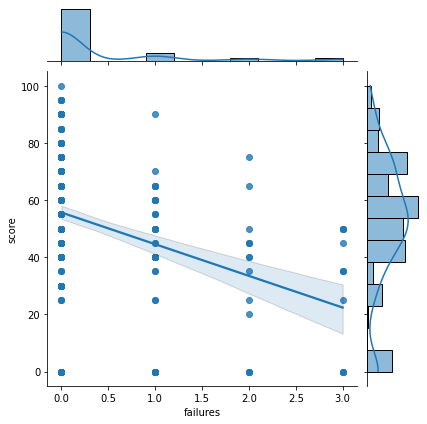

In [75]:
# Видна зависимость оценки теста от количества замечаний.
sns.jointplot(y='score', x='failures', data=students_raw, kind='reg')

## schoolsup — дополнительная образовательная поддержка (yes или no)

In [76]:
students_raw.schoolsup.value_counts(dropna=False)

no     334
yes     51
NaN      9
Name: schoolsup, dtype: int64

schoolsup — уникальных значений 2, других значений нет, значит в данных нет опечаток, но есть пропуски - 9.

In [77]:
students_raw.schoolsup.fillna(students_raw.schoolsup.mode()[0], inplace=True)
students_raw.schoolsup.unique()

array(['yes', 'no'], dtype=object)

<AxesSubplot:xlabel='schoolsup', ylabel='score'>

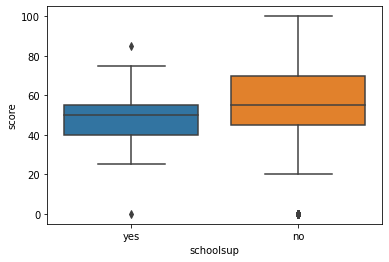

In [78]:
sns.boxplot(y='score', x='schoolsup', data=students_raw)

__Вывод:__ Признак категориальный, 9 пропусков. Похоже, дополнительой поддержкой пользовались плохо успевающие студенты, но она помогала им лишь отчасти. Заменил пропуски на моду.

## famsup — семейная образовательная поддержка (yes или no)

In [79]:
students_raw.famsup.value_counts(dropna=False)

yes    219
no     136
NaN     39
Name: famsup, dtype: int64

Признак категориальный, ошибок ввода нет, пропусков чуть менее 10%. Заменил пропуски на моду.

In [80]:
students_raw.famsup.fillna(students_raw.famsup.mode()[0], inplace=True)
students_raw.famsup.unique()

array(['no', 'yes'], dtype=object)

<AxesSubplot:xlabel='famsup', ylabel='score'>

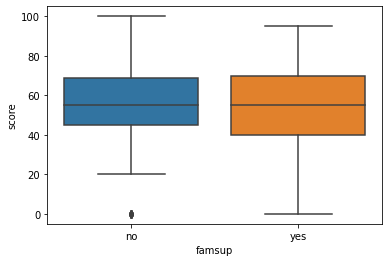

In [81]:
sns.boxplot(y='score', x='famsup', data=students_raw)

## paid — дополнительные платные занятия по математике (yes или no)

In [82]:
students_raw.paid.value_counts(dropna=False)

no     199
yes    155
NaN     40
Name: paid, dtype: int64

In [83]:
students_raw.paid.fillna('N', inplace=True)
students_raw.paid.unique()

array(['no', 'N', 'yes'], dtype=object)

<AxesSubplot:xlabel='paid', ylabel='score'>

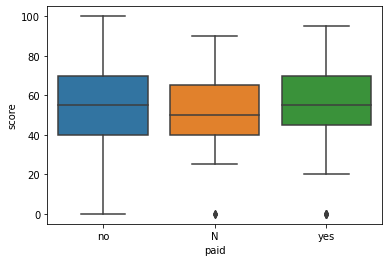

In [84]:
sns.boxplot(y='score', x='paid', data=students_raw)

__Вывод:__ Признак категориальный, 40 пропусков, ошибок ввода нет. Заменил пропуски на новое значение - N.

## activities — дополнительные внеучебные занятия (yes или no)

In [85]:
students_raw.activities.value_counts(dropna=False)

yes    195
no     185
NaN     14
Name: activities, dtype: int64

In [86]:
students_raw.activities.fillna(students_raw.activities.mode()[0], inplace=True)
students_raw.activities.unique()

array(['no', 'yes'], dtype=object)

<AxesSubplot:xlabel='activities', ylabel='score'>

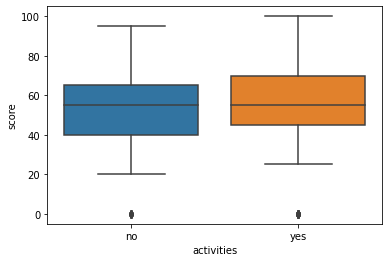

In [87]:
sns.boxplot(y='score', x='activities', data=students_raw)

__Вывод:__ Признак категориальный, 14 пропусков, ошибок ввода нет. Заменил пропуски на самое частое значение.

## nursery — посещал детский сад (yes или no)

In [88]:
students_raw.nursery.value_counts(dropna=False)

yes    300
no      78
NaN     16
Name: nursery, dtype: int64

In [89]:
students_raw.nursery.fillna(students_raw.nursery.mode()[0], inplace=True)
students_raw.nursery.unique()

array(['yes', 'no'], dtype=object)

<AxesSubplot:xlabel='nursery', ylabel='score'>

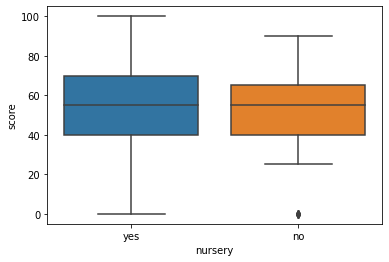

In [90]:
sns.boxplot(y='score', x='nursery', data=students_raw)

__Вывод:__ Признак категориальный, 16 пропусков. В колонке nursery не было ошибочных данных, пропуски мы заменили на самое часто встречающееся значение - yes, примено 80% учащихся посещали детский сад.

## studytime, granular - признак, не указанный в описании

In [91]:
# для удобства сначала переименуем его
# students_raw.rename({'studytime, granular': 'st_gran'}, axis='columns', inplace=True)

In [92]:
# students_raw.st_gran.value_counts(dropna=False)

In [93]:
# # признак коррелирует с признаком studytime
# sns.jointplot(y='studytime', x='st_gran', data=students_raw, kind='reg')

In [94]:
# students_raw[['studytime', 'st_gran']].corr()

__Вывод:__ Признак категориальный, 7 пропусков. Полностью коррелирует с признаком studytime, поэтому для нас ценности не представляет. Удалим его сразу же.

In [95]:
# students_raw.drop('st_gran', axis='columns', inplace=True)

## higher — хочет получить высшее образование (yes или no)

In [96]:
students_raw.higher.value_counts(dropna=False)

yes    356
NaN     20
no      18
Name: higher, dtype: int64

In [97]:
students_raw.higher.fillna(students_raw.higher.mode()[0], inplace=True)
students_raw.higher.unique()

array(['yes', 'no'], dtype=object)

<AxesSubplot:xlabel='higher', ylabel='score'>

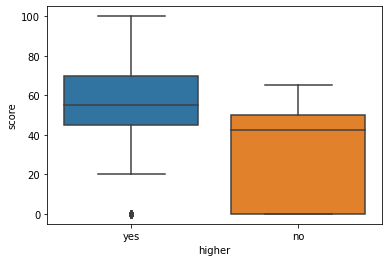

In [98]:
sns.boxplot(y='score', x='higher', data=students_raw)

__Вывод:__ Признак категориальный, 20 пропусков. Взаимосвязь с результатом сильная. Заменил пропуски на 'yes'.

## internet — наличие интернета дома (yes или no)

In [99]:
students_raw.internet.value_counts(dropna=False)

yes    304
no      56
NaN     34
Name: internet, dtype: int64

In [100]:
students_raw.internet.fillna(students_raw.internet.mode()[0], inplace=True)
students_raw.internet.unique()

array(['yes', 'no'], dtype=object)

<AxesSubplot:xlabel='internet', ylabel='score'>

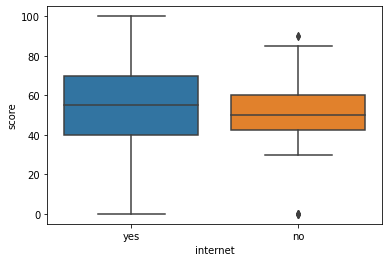

In [101]:
sns.boxplot(y='score', x='internet', data=students_raw)

__Вывод:__ Признак категориальный, 34 пропуска. Взаимосвязь с результатом незначительная. Заменил пропуски на 'yes'

## romantic — в романтических отношениях (yes или no)

In [102]:
students_raw.romantic.value_counts(dropna=False)

no     240
yes    123
NaN     31
Name: romantic, dtype: int64

In [103]:
students_raw.romantic.fillna(students_raw.romantic.mode()[0], inplace=True)
students_raw.romantic.unique()

array(['no', 'yes'], dtype=object)

In [104]:
students_raw.romantic = students_raw.romantic.astype(str).apply(
    lambda x: 'yes' if x.strip() == 'N' else x)

<AxesSubplot:xlabel='romantic', ylabel='score'>

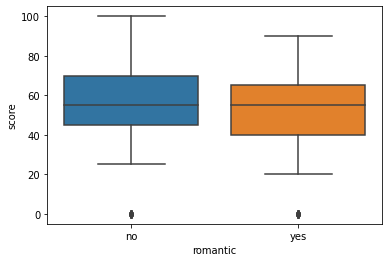

In [105]:
sns.boxplot(y='score', x='romantic', data=students_raw)

__Вывод:__ Признак категориальный, 31 пропуск ошибок ввода нет. Заменил на моду - 'no'.

## famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [106]:
students_raw.famrel.value_counts(dropna=False)

 4.0    182
 5.0     98
 3.0     62
 NaN     27
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

<AxesSubplot:>

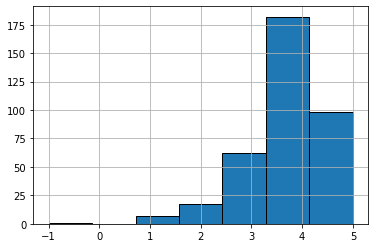

In [107]:
students_raw.famrel.hist(bins=7)

Вероятнее всего, единственное значение признака -1.0 - ошибка заполнения. Исправляю ее, заменив значение на 1.0.

In [108]:
students_raw.loc[students_raw.famrel == -1.0, 'famrel'] = 1.0

In [109]:
students_raw.famrel.fillna(students_raw.famrel.mode()[0], inplace=True)
students_raw.famrel.unique()

array([4., 5., 3., 1., 2.])

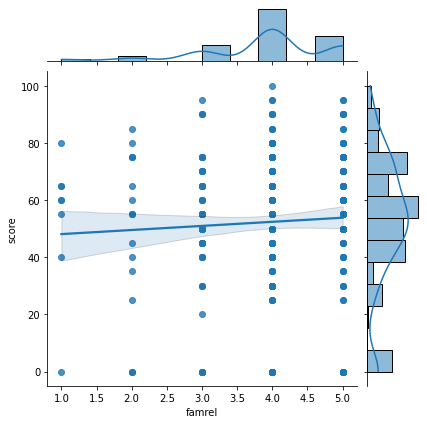

In [110]:
sns.jointplot(y='score', x='famrel', data=students_raw, kind='reg')

__Вывод:__ Признак ординальный, 27 пропусков, 1 явный выброс(вероятно, опечатка). Заменил выброс на 1, пропуски на самое частое значение 4.

## freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [111]:
students_raw.freetime.value_counts(dropna=False)

3.0    153
4.0    111
2.0     63
5.0     38
1.0     18
NaN     11
Name: freetime, dtype: int64

<AxesSubplot:>

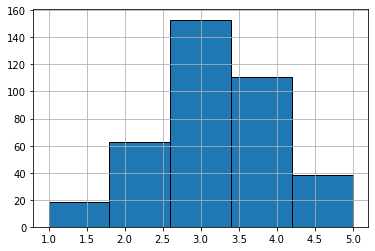

In [112]:
students_raw.freetime.hist(bins=5)

In [113]:
students_raw.freetime.fillna(students_raw.freetime.mode()[0], inplace=True)
students_raw.freetime.unique()

array([3., 2., 4., 1., 5.])

<AxesSubplot:xlabel='freetime'>

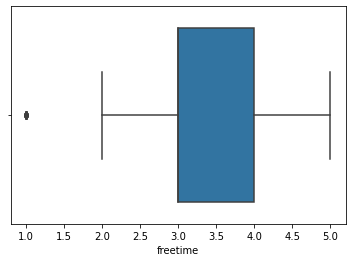

In [114]:
# присмотримся, есть ли выбросы
sns.boxplot(x='freetime', data=students_raw)

Отношения в семье на уровне 1.0 - очень плохие - похожи на выброс. Но решил записи с этим значением признака не удалять. Все равно, похоже, признак нам не пригодится для модели, так как визуально слабо коррелирует с результатом:

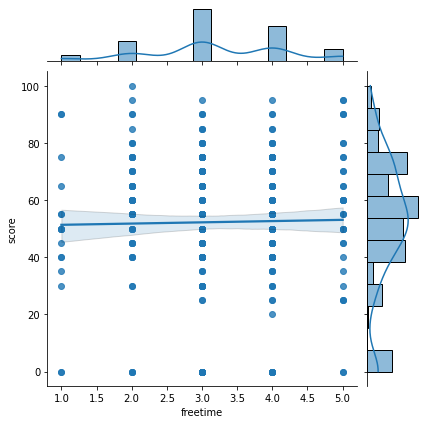

In [115]:
sns.jointplot(y='score', x='freetime', data=students_raw, kind='reg')

__Вывод:__ Признак ординальный, 11 пропусков, ошибок заполнения нет. Заменил пропуски на самое частое значение 3.0.

## goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [116]:
students_raw.goout.value_counts(dropna=False)

3.0    127
2.0    101
4.0     84
5.0     51
1.0     23
NaN      8
Name: goout, dtype: int64

In [117]:
students_raw.goout.fillna(students_raw.goout.mode()[0], inplace=True)
students_raw.goout.value_counts()

3.0    135
2.0    101
4.0     84
5.0     51
1.0     23
Name: goout, dtype: int64

<AxesSubplot:>

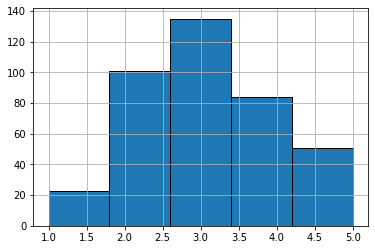

In [118]:
students_raw.goout.hist(bins=5)

<AxesSubplot:xlabel='goout'>

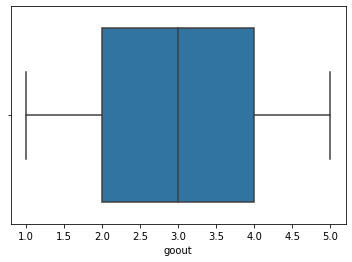

In [119]:
# присмотримся, есть ли выбросы
sns.boxplot(x='goout', data=students_raw)

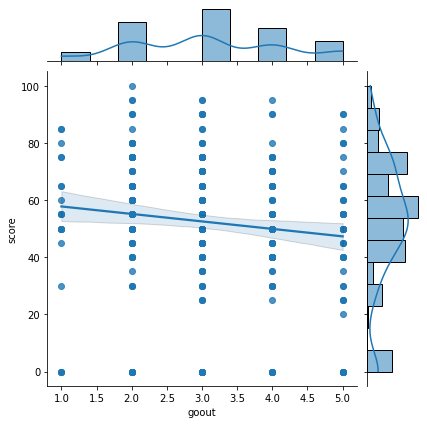

In [120]:
sns.jointplot(y='score', x='goout', data=students_raw, kind='reg')

__Вывод:__ Признак ординальный, 8 пропусков, ошибок ввода нет.  Заменил пропуски на моду.

## health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [121]:
students_raw.health.value_counts(dropna=False)

5.0    138
3.0     89
4.0     63
1.0     46
2.0     43
NaN     15
Name: health, dtype: int64

In [122]:
students_raw.health.fillna(students_raw.health.mode()[0], inplace=True)
students_raw.health.value_counts()

5.0    153
3.0     89
4.0     63
1.0     46
2.0     43
Name: health, dtype: int64

<AxesSubplot:>

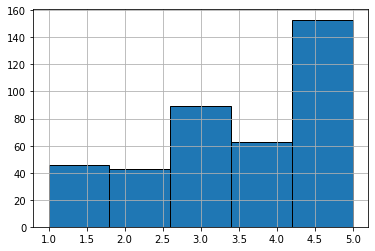

In [123]:
students_raw.health.hist(bins=5)

<AxesSubplot:xlabel='health'>

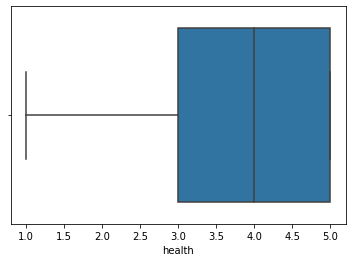

In [124]:
sns.boxplot(x='health', data=students_raw)

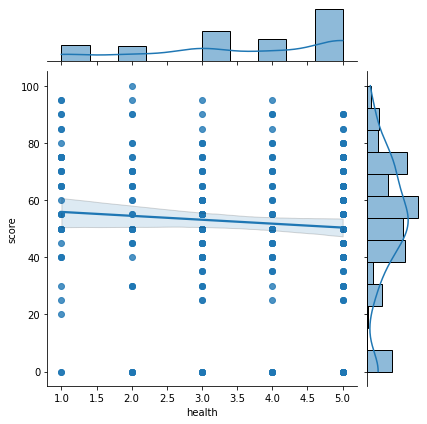

In [125]:
sns.jointplot(y='score', x='health', data=students_raw, kind='reg')

Признак ординальный, ошибок нет, 15 пропусков. В итоге заменил пропуски на самое частое значение. 

## absences — количество пропущенных занятий

In [126]:
# признак числовой, основная масса значений находится в интервале от 0 до 20 занятий, есть 12 пропусков
students_raw.absences.value_counts(dropna=False).head(10)

0.0     111
2.0      60
4.0      53
6.0      31
8.0      21
10.0     17
NaN      12
14.0     12
12.0     12
3.0       8
Name: absences, dtype: int64

In [127]:
# Заполним пропуски самым частым значением:
students_raw.absences.fillna(students_raw.absences.mode()[0], inplace=True)

<AxesSubplot:xlabel='absences'>

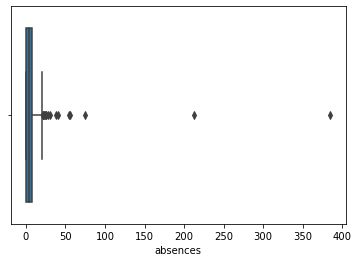

In [128]:
# проверим, где находятся выбросы
sns.boxplot(x='absences', data=students_raw)

<AxesSubplot:>

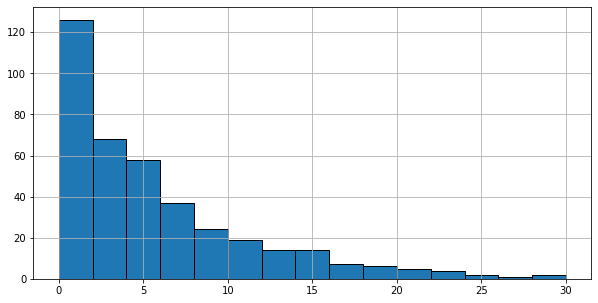

In [129]:
# несколько сот часов пропуска занятий - явные выбросы, похоже, в школьном курсе нет столько часов математики
# рассмотрим пропуски в разумных пркеделах(верхняя граница коробки на графике выше равна примерно 30)
students_raw[students_raw.absences <= 30].absences.hist(bins=15, figsize=(10, 5))

In [130]:
# найдем выбросы с помощью нашей функции outliers_iqr и удалим их:
outliers = outliers_datacolumn(students_raw.absences)
outlier_data = get_outliers(outliers, students_raw.absences, students_raw)
if not outlier_data.empty:
    display(outlier_data)

q1 = 0.0, q3 = 8.0, borders = (-12.0, 20.0)
Выбросы в колонке 'absences': 40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64
Выбросы в колонке 'absences' ЕСТЬ: 17 выброс(а/ов)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,yes,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,N,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,N,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,yes,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,other,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,N,4.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,yes,no,no,no,-6.0,no,yes,yes,4.0,1.0,1.0,5.0,75.0,45.0


In [131]:
# всего мы удалим 17 записей, будем надеяться, что модель,
# обученная на оставшемся датасете, будет работать точнее
print(f"""Общее количество записей до удаления выбросов: {len(students_raw)}""")
drop_outliers(outliers, students_raw.absences, students_raw)
print(f"""Общее количество записей после удаления выбросов: {len(students_raw)}""")

Общее количество записей до удаления выбросов: 394
Общее количество записей после удаления выбросов: 377


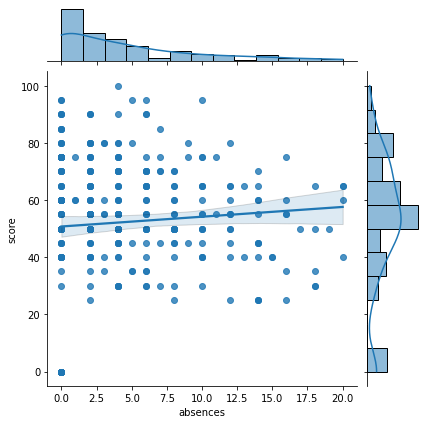

In [132]:
# взглянем на корреляцию с результатом
sns.jointplot(x='absences', y='score', data=students_raw, kind='reg')

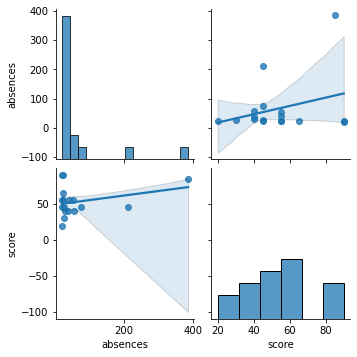

In [133]:
sns.pairplot(outlier_data[["absences", "score"]], kind='reg')

Коэффициент корреляции меду числом пропусков и оценкой за математику положителен и равен 0.29.
Те, кто пропускают занятия имеют посредственные оценки,<br />
а некоторые студенты, постоянно пропускающие занятия, имеют высокий балл.<br />
Возможно это означает, что школьные занятия по математике нуждаются в повышении качества.<br />

Так или иначе можно удалить эти 17 выбросов,<br />
которые относятся к студентам, которые не посещают занятия регулярно.<br />
Основная их масса закономерно имеют низкие отметки по математике,
а некоторые имеют высокие, поскольку видимо имеют повышенные способности.

Почти все студенты, игнорирующие посещение занятий учатся в школе с аббревиатурой "GP".

__Вывод:__ Признак числовой, 12 пропусков. В этом признаке явно есть выбросы - единичные студенты пропустили очень много занятий. Избавились от этих выбросов. Пропуски заполнили модой = 0.0

## score — баллы по госэкзамену по математике

In [134]:
students_raw.score.value_counts(dropna=False)

50.0     54
55.0     42
0.0      37
75.0     33
60.0     31
65.0     30
70.0     27
40.0     27
45.0     23
80.0     16
30.0     14
90.0     10
35.0      9
25.0      7
NaN       6
85.0      5
95.0      5
100.0     1
Name: score, dtype: int64

In [135]:
# имеем 6 пропусков, чтобы грамотно заполнить их, вычислим статистики:
students_raw.score.describe(), students_raw.score.mode()

(count    371.000000
 mean      52.264151
 std       23.094876
 min        0.000000
 25%       40.000000
 50%       55.000000
 75%       70.000000
 max      100.000000
 Name: score, dtype: float64,
 0    50.0
 Name: score, dtype: float64)

In [136]:
# видим, что значения статистик близки, заполняем пропуски модой
students_raw.score.fillna(students_raw.score.mode()[0], inplace=True)

<AxesSubplot:>

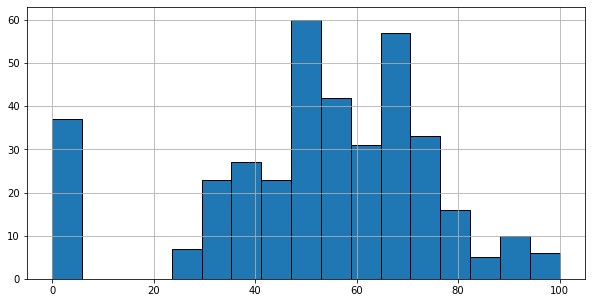

In [137]:
# гистограмма признака score
students_raw.score.hist(bins=17, figsize=(10, 5))

Посмотрим на статистику результата. Выясним, где находятся границы выбросов. Нулевой результат - это выброс или нет? По смыслу - должен быть выбросом (в школьном тесте по математике всегда есть пара задач, которая под силу любому человеку).

<AxesSubplot:xlabel='score'>

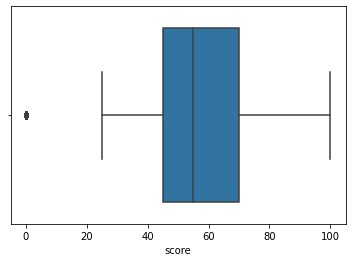

In [138]:
# сначала присмотримся к boxplot - он нам показывает, что ноль - это выброс
# оставляем выброс в данных, иначе потеряем 37 записей.
sns.boxplot(x='score', data=students_raw)

__Вывод:__ целевая переменная score - числовая, в диапазоне от 0 до 100, со средними величинами между 50 и 55. Предположительно 0 - это выброс, остальные значения в диапазоне от 25 до 100, что соответствует обычным школьным оценкам.

In [139]:
students_raw.isnull().sum()

school                 0
sex                    0
age                    0
address                0
famsize                0
Pstatus                0
Medu                   0
Fedu                   0
Mjob                   0
Fjob                   0
reason                 0
guardian               0
traveltime             0
studytime              0
failures               0
schoolsup              0
famsup                 0
paid                   0
activities             0
nursery                0
studytime, granular    7
higher                 0
internet               0
romantic               0
famrel                 0
freetime               0
goout                  0
health                 0
absences               0
score                  0
dtype: int64

### Колонка "studytime, granular"

Указанная колонка не описана в итоговом задании.<br />
Она содержит некоторый набор отрицательных чисел.
Проверим, что все числа из колонки "studytime, granular"<br />
соответствуют значениям из колонки "studytime" по простой формуле:

\begin{equation}
\text{"studytime, granular"} = -3.0 \cdot \text{studytime}\,,\tag{1}
\end{equation}

где $\text{studytime} \in \lbrace NaN, 1.0, 2.0, 3.0, 4.0 \rbrace$.<br />
Ниже приведён код этой проверки с использованием неизменённых данных из<br />
объекта `students_raw` типа `DataFrame`.

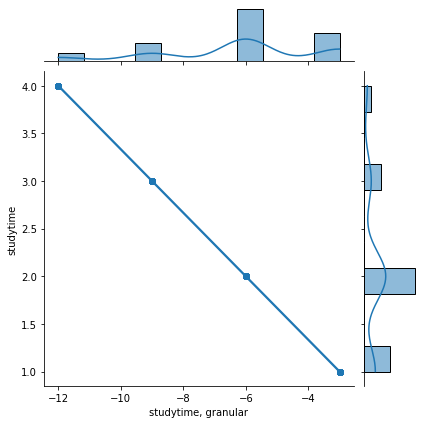

In [140]:
# признак коррелирует с признаком studytime
sns.jointplot(y='studytime', x='studytime, granular', data=students_raw, kind='reg')

In [141]:
students_raw[['studytime', 'studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


На основании положительного ответа на последний вопрос можно сделать вывод,<br />
что данные колонки "studytime, granular" не привносят какой-либо новой информации о<br />
студентах в таблицу "students_raw" и, как следствие в предобработанную таблицу "students".<br />
Для информации о примерном количестве часов дополнительного обучения вне школы<br />
можно и далее использовать колонку "studytime".

На основании этого вывода мы можем удалить колонку "studytime, granular" из таблицы "students".

In [142]:
students_raw.drop("studytime, granular", inplace=True, axis=1)

### Отображение первых нескольких строк очищенных данных

In [143]:
display(students_raw.head(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,N,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,N,no,yes,yes,yes,no,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,U,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,GT3,N,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Сводная информация об очищенных данных для проверки

In [144]:
students_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      377 non-null    object 
 1   sex         377 non-null    object 
 2   age         377 non-null    int64  
 3   address     377 non-null    object 
 4   famsize     377 non-null    object 
 5   Pstatus     377 non-null    object 
 6   Medu        377 non-null    float64
 7   Fedu        377 non-null    float64
 8   Mjob        377 non-null    object 
 9   Fjob        377 non-null    object 
 10  reason      377 non-null    object 
 11  guardian    377 non-null    object 
 12  traveltime  377 non-null    float64
 13  studytime   377 non-null    float64
 14  failures    377 non-null    float64
 15  schoolsup   377 non-null    object 
 16  famsup      377 non-null    object 
 17  paid        377 non-null    object 
 18  activities  377 non-null    object 
 19  nursery     377 non-null    o

## Корреляционный анализ количественных переменных

__В датасете присутствуют числовые, ординальные и номинативные признаки. Значения ординальных признаков закодированы цифрами, что позволяет судить об их корреляции с результатом.__

### Матрица корреляций

In [145]:
correlations = students_raw.corr()
display(correlations)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.184695,-0.162145,0.095785,0.003321,0.183434,0.047508,0.041976,0.133867,-0.037371,0.118910,-0.160019
Medu,-0.184695,1.000000,0.590367,-0.175593,0.092968,-0.259936,-0.013531,0.048128,0.052213,-0.062151,0.067635,0.207056
Fedu,-0.162145,0.590367,1.000000,-0.124146,0.010331,-0.271200,-0.014291,-0.016392,0.043224,-0.012670,-0.028300,0.120318
traveltime,0.095785,-0.175593,-0.124146,1.000000,-0.084203,0.063751,-0.014571,-0.000595,0.048009,-0.046815,-0.023108,-0.055152
studytime,0.003321,0.092968,0.010331,-0.084203,1.000000,-0.165533,0.039320,-0.128670,-0.033993,-0.077406,-0.064534,0.117043
failures,0.183434,-0.259936,-0.271200,0.063751,-0.165533,1.000000,-0.030887,0.075332,0.083284,0.105170,0.053226,-0.334069
famrel,0.047508,-0.013531,-0.014291,-0.014571,0.039320,-0.030887,1.000000,0.162352,0.066266,0.089031,-0.084492,0.065295
freetime,0.041976,0.048128,-0.016392,-0.000595,-0.128670,0.075332,0.162352,1.000000,0.276817,0.060200,0.079144,0.039026
goout,0.133867,0.052213,0.043224,0.048009,-0.033993,0.083284,0.066266,0.276817,1.000000,0.004749,0.081667,-0.108463
health,-0.037371,-0.062151,-0.012670,-0.046815,-0.077406,0.105170,0.089031,0.060200,0.004749,1.000000,-0.004537,-0.085332


### Парные диаграммы с регрессиями

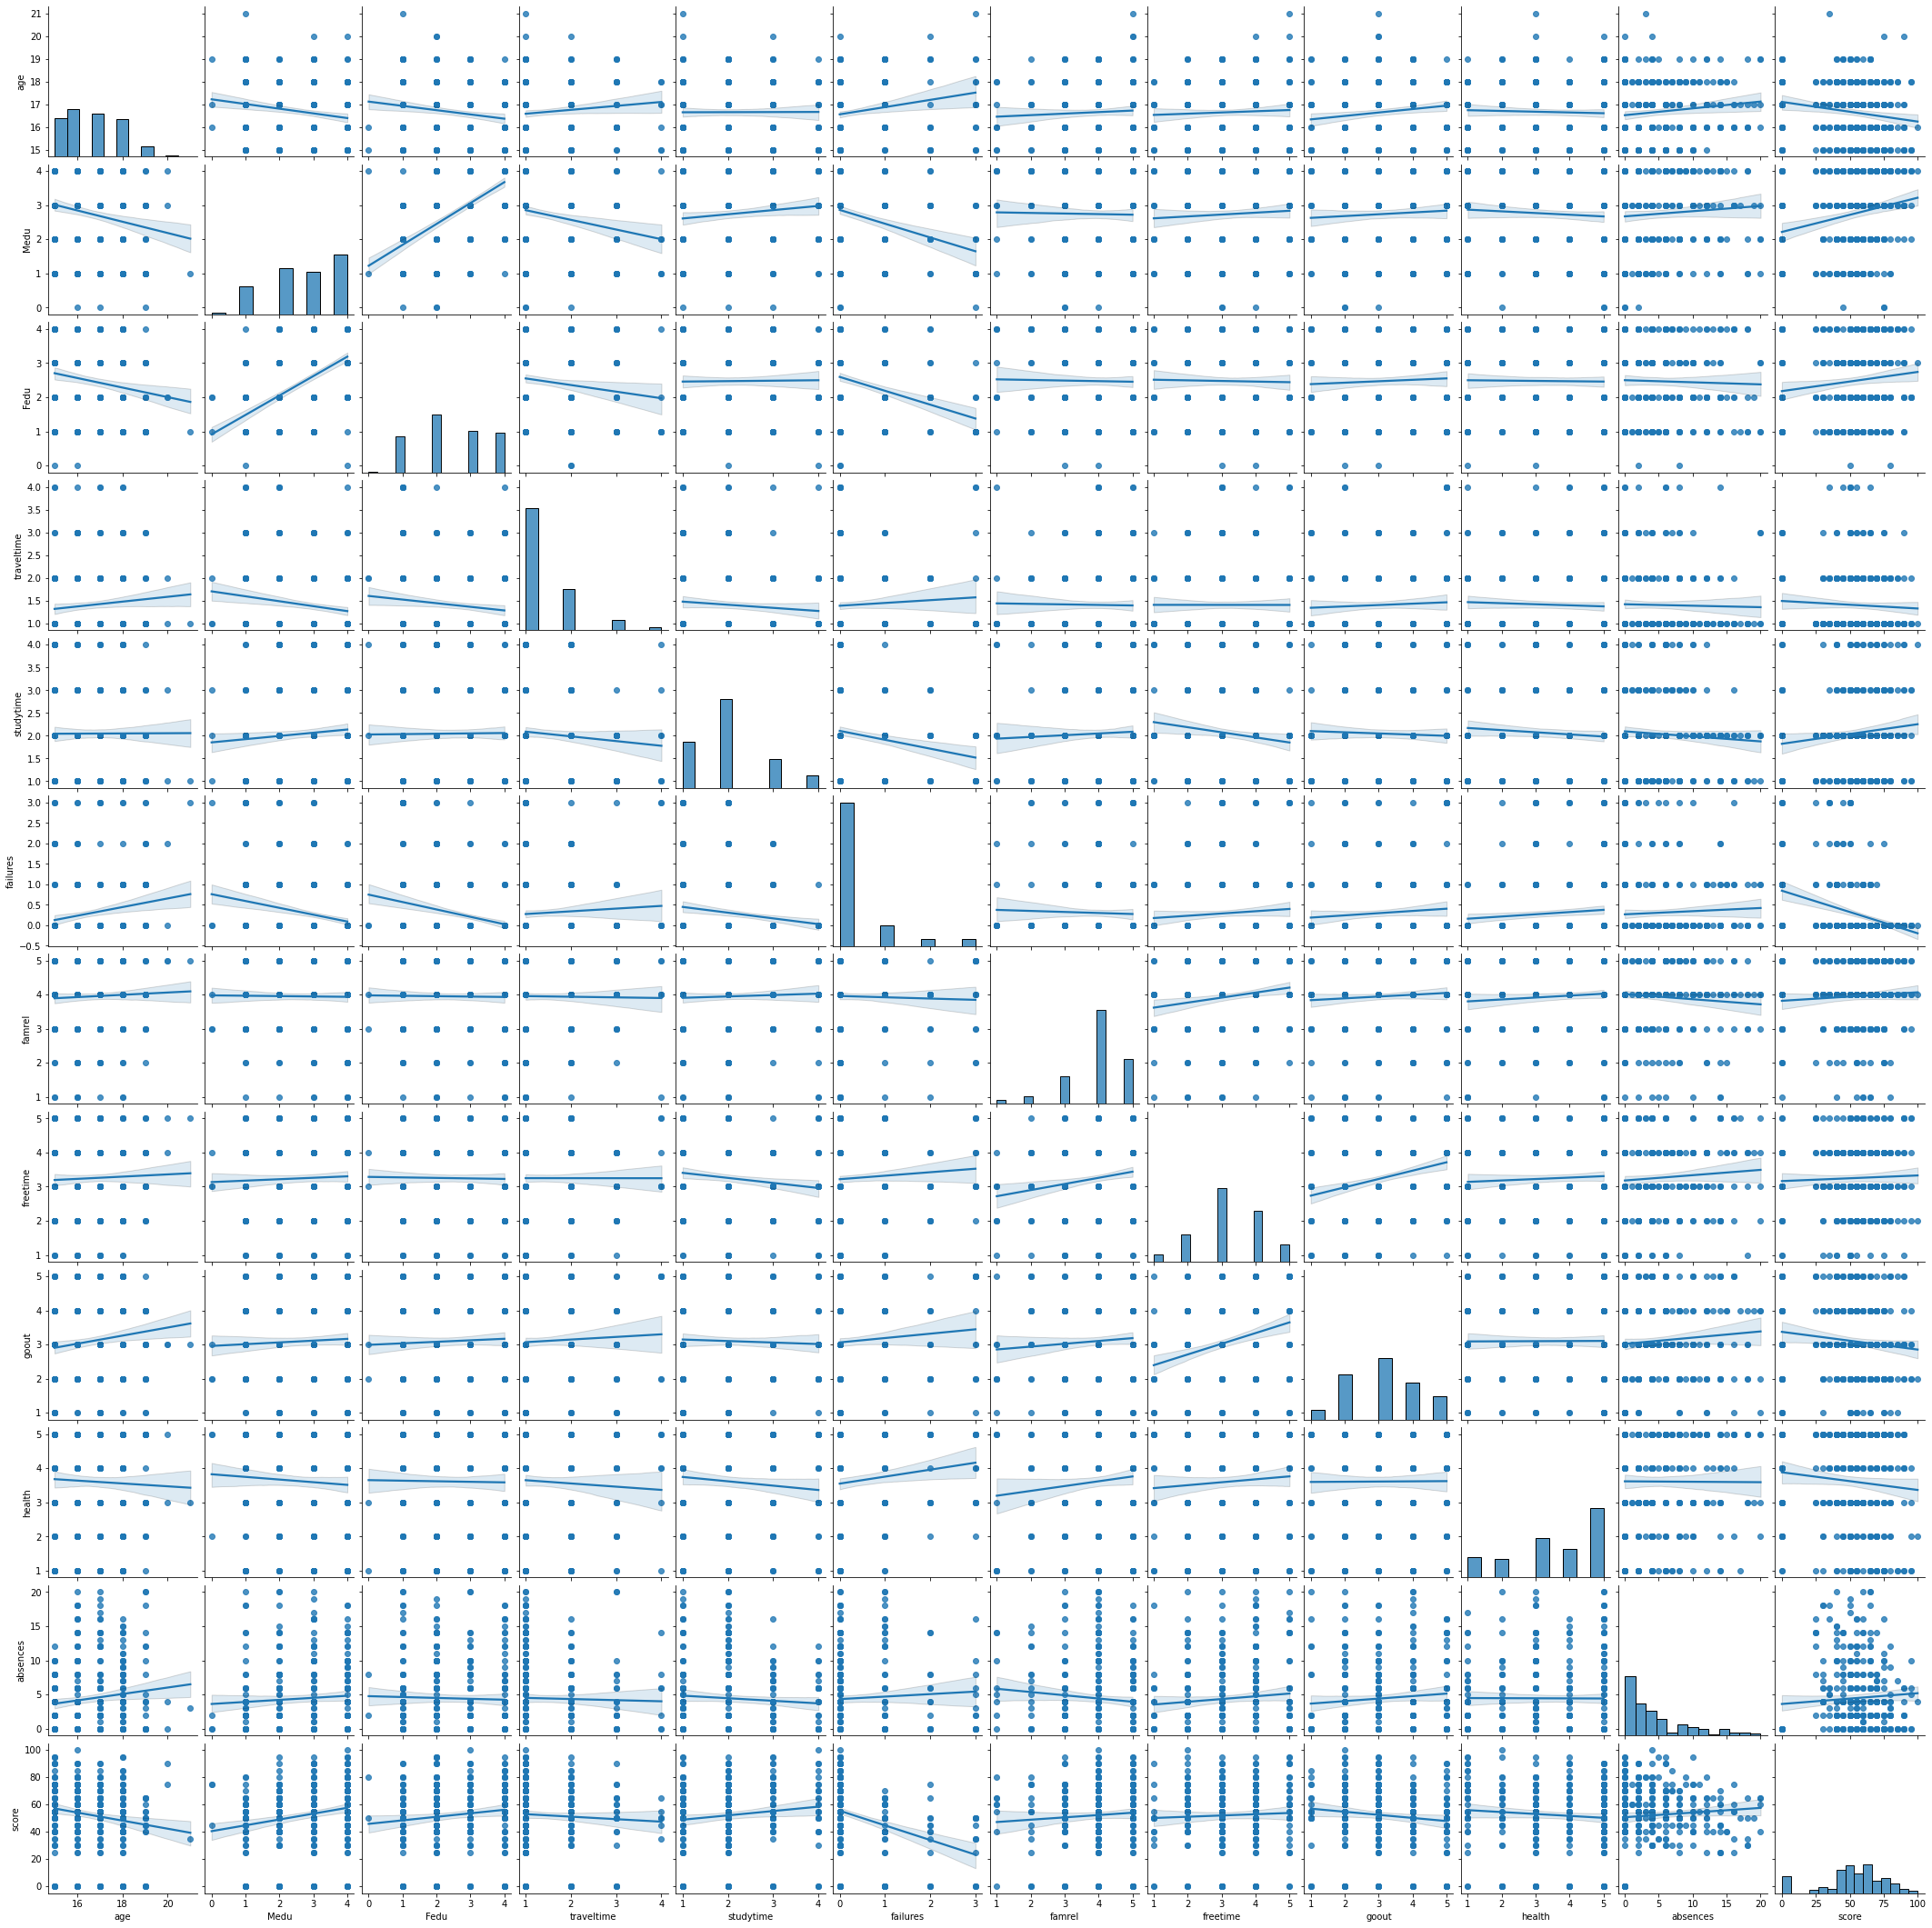

In [146]:
sns.pairplot(students_raw, kind='reg')

По графикам видна корреляция некоторых признаков с результатом. Выберем для построения модели наиболее коррелирующие (модуль коэффициента более 0.1). Это несложно сделать в несколько строчек.
Бросается в глаза отрицательная корреляция между числом пропусков занятий и экзаменационной оценкой.

### Коэффициэнты корреляции с экзаменационными оценками.

In [147]:
correlations_score = correlations["score"]
display(correlations_score)

age          -0.160019
Medu          0.207056
Fedu          0.120318
traveltime   -0.055152
studytime     0.117043
failures     -0.334069
famrel        0.065295
freetime      0.039026
goout        -0.108463
health       -0.085332
absences      0.073363
score         1.000000
Name: score, dtype: float64

In [148]:
display(correlations_score.abs().sort_values(ascending=False))

score         1.000000
failures      0.334069
Medu          0.207056
age           0.160019
Fedu          0.120318
studytime     0.117043
goout         0.108463
health        0.085332
absences      0.073363
famrel        0.065295
traveltime    0.055152
freetime      0.039026
Name: score, dtype: float64

In [149]:
# находим таблицу корреляций признаков (по абсолютной величине)
corrs = students_raw.corr().abs().unstack().sort_values(ascending=False)

In [150]:
# выбираем из них те, что коррелируют с коэффицентом более 0.1
corr_pairs = corrs[corrs.values > 0.1].reset_index()
corr_pairs

,level_0,level_1,0
0,age,age,1.000000
1,Medu,Medu,1.000000
2,absences,absences,1.000000
3,health,health,1.000000
4,goout,goout,1.000000
...,...,...,...
49,studytime,score,0.117043
50,goout,score,0.108463
51,score,goout,0.108463
52,failures,health,0.105170


In [151]:
corr_pairs.head()

,level_0,level_1,0
0,age,age,1.0
1,Medu,Medu,1.0
2,absences,absences,1.0
3,health,health,1.0
4,goout,goout,1.0


In [152]:
# Выбираем те пары, где одна из переменных - целевая, вторые признаки собираем в список
high_linear_correlation_columns = corr_pairs[(corr_pairs.level_0 == 'score') & (
    corr_pairs.level_1 != 'score')].level_1.tolist()

high_linear_correlation_columns

['failures', 'Medu', 'age', 'Fedu', 'studytime', 'goout']

Из столбца `correlations_score` для корреляционных коэффициентов для экзаменационных отметок видно, что<br />
могут иметься следующие положительные связи, влияющие на более высокий балл:
- Medu - score: Чем выше уровень образования матери, тем выше отметка по математике;
- Fedu - score: Чем выше уровень образования отца, тем выше отметка по математике;
- studytime - score: Чем больше времени вне школы проведено за учёбой, тем выше отметка по математике;

Стоит также заметить, в предложенном наборе данных уровень образования у отцов в среднем ниже чем у матерей,
что могло повлиять на более низкое значение коэффициента корреляции Fedu - score по сравнению с
Medu - score.

**Вывод 1:** Более высокий уровень образования родителей и большее время для занятий дома повышают вероятноть получения учеником более высоких баллов за гос. экзамен по математике.

*Несмотря на большую корреляцию между уровнем образования матери и отца, стоит оставить оба эти параметра, поскольку они оба могут существенно влиять в паре на построение итоговой модели.*

---
Из столбца `correlations_score` для корреляционных коэффициентов для экзаменационных отметок видно, что<br />
могут иметься следующие отрицательные связи, влияющие на более низкий балл:
 - age - score: Чем больше возраст ученика, тем более низкие отметки по математике он может получить;
 - failures - score: Чем больше у ученика было различных неудач, не связанных с учёбой в школе, тем обльше вероятность, что он получит плохие отметки на экзамене;
 - goout - score: Время, затраченное не на учёбу в школе, а на общение с друзьями понижает отметки по математике;
 - absences - score: Чем больше ученик пропускает занятий, тем больше вероятноть, что он получит более низкую отметку по матемеатике;
 - health - score: Имеется небольшая отрицательная корреляция между уровнем здоровья ученика и его отметкой по математике;
 - traveltime - score: Есть слабое отрицательное влияние увеличения времени поездки до школы на более низкую отметку по матекатике.

**Вывод 2:** У ученика, у которого повышен уровень внеучебных неудач, который часто пропускает занятия, тратит время не на учёбу, а на праздное общение с друзьями чаще всего получает более низкие отметки за гос. экзамен по математике. Эти отметки также могут ухудшаться при воздействии фактора возраста ученика: чем возраст выше, тем отметка по математике хуже. Небольшую добавку в ухудшение отметки может внести падение уровня здоровья учащегося и увеличение веремени, затрачиваемого на дорогу до школы.

---

Из столбца `correlations_score` для корреляционных коэффициентов для экзаменационных отметок видно, что<br />
имеются отсутствующие или низкие связи с некоторыми факторами, практически не влияющими на оценку по математике:
- famrel - score: Имеется слабая положительная связь между отношениями в семье и отметкой по математике;
- freetime - score: Практически отсутствует связь между личным свободным временем ученика и его отметкой по математике, из чего можно сделать вывод что это время он тратит исключительно на себя, а не на друзей (фактор groot).

**Вывод 3:** Личное свободное время ученика почти никак не влияяет на его отметку за гос. экзамен по математике.
Улучшение семейных отношений может очень слабо повлиять на увеличение отметки.

### Переменные, не коррелирующие с отметкой за экзамен:
- freetime

Принято решение исключить переменную freetime из итоговой модели.

### Дублирующиеся переменные, полностью коррелирующие:
- "studytime, granular";
- studytime

Принято решение оставить только переменную studytime.

### Коррелирующие с преременной score переменные, влияющие на отметку за экзамен:
- Положительно коррелирующие:
  - Medu;
  - Fedu;
  - studytime;
- Отрицательно коррелирующие:
  - age;
  - failures;
  - goout.

__Вывод:__ Из ординальных и числовых признаков для модели выбираем ['failures', 'Medu', 'age', 'Fedu', 'studytime', 'goout']

## Анализ номинативных переменных

#### Диаграммы Boxplot

In [153]:
def nominative_analysis(col):
    global nominative_columns_important

    # Проверка на строковый тип данных, которым закодированы номинативные признаки
    if students_raw.loc[:, col].dtypes == np.dtype('O'):

        # печать наименования признака и графика
        print('Столбец', col)
        print('Распределение баллов по значениям признака:')

        # построение боксплотов распределения целевой переменной от значения признака
        fig, ax = plt.subplots(figsize=(14, 4))
        sns.boxplot(x=col, y='score',
                    data=students_raw,
                    ax=ax)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + col)
        plt.show()

        # разбиваем значения признаков на пары и тестируем зависимость целевой переменной
        pairs_all = list(combinations(students_raw.loc[:, col].dropna().unique(), 2))
        for pair in pairs_all:
            if ttest_ind(students_raw.loc[students_raw.loc[:, col] == pair[0], 'score'],
                         students_raw.loc[students_raw.loc[:, col] == pair[1], 'score']).pvalue \
                    <= 0.05/len(pairs_all):  # Учли поправку Бонферони
                print('Найдены статистически значимые различия для колонки', col)
                nominative_columns_important.append(col)
                break
        print('----------------------------------')
        print()

Столбец school
Распределение баллов по значениям признака:


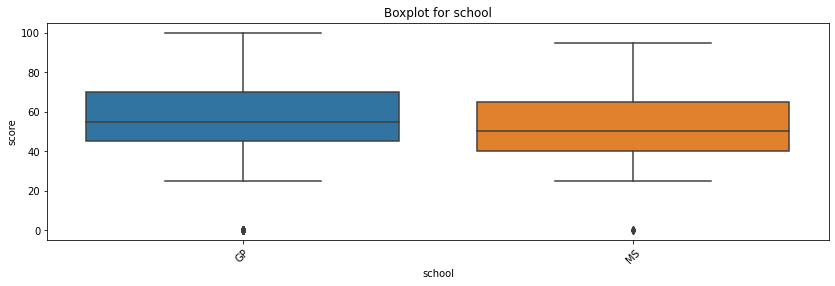

----------------------------------

Столбец sex
Распределение баллов по значениям признака:


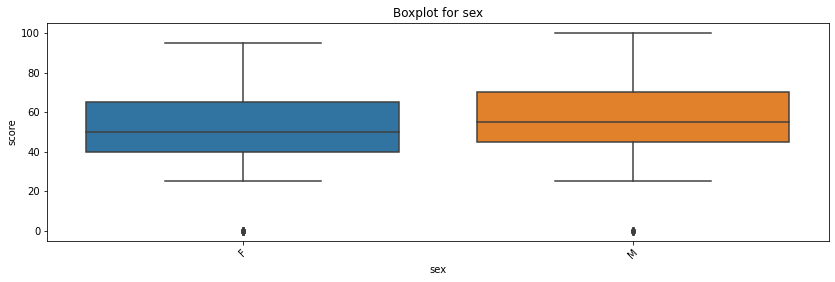

Найдены статистически значимые различия для колонки sex
----------------------------------

Столбец address
Распределение баллов по значениям признака:


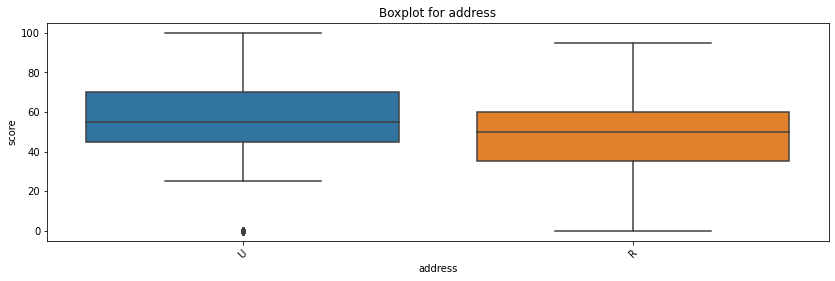

Найдены статистически значимые различия для колонки address
----------------------------------

Столбец famsize
Распределение баллов по значениям признака:


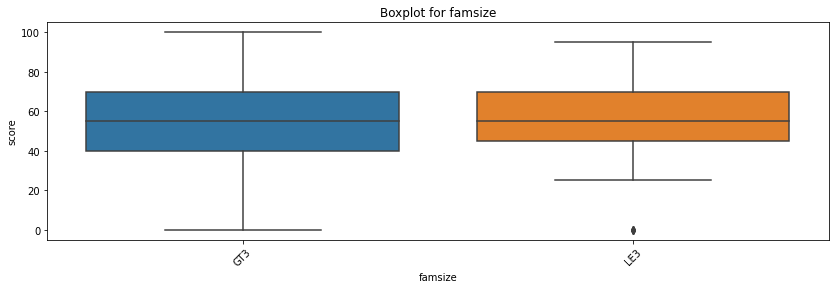

----------------------------------

Столбец Pstatus
Распределение баллов по значениям признака:


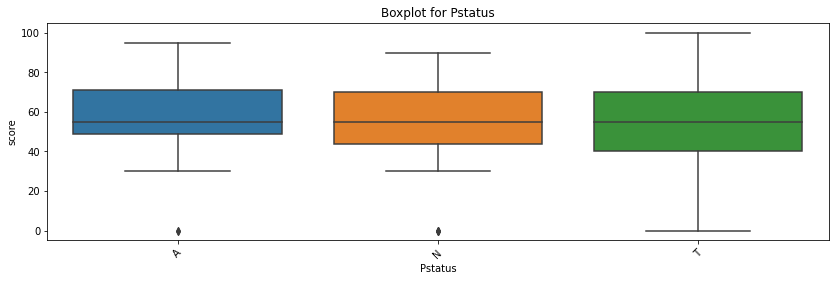

----------------------------------

Столбец Mjob
Распределение баллов по значениям признака:


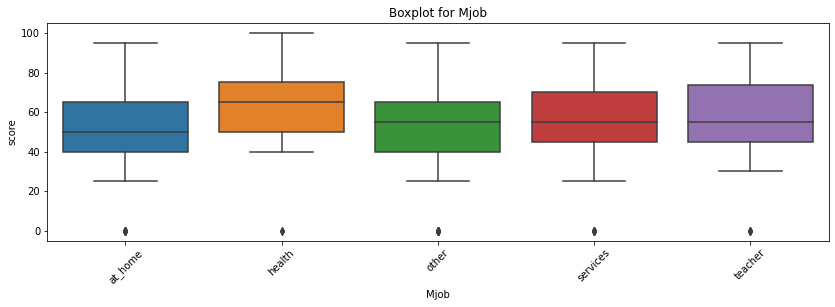

Найдены статистически значимые различия для колонки Mjob
----------------------------------

Столбец Fjob
Распределение баллов по значениям признака:


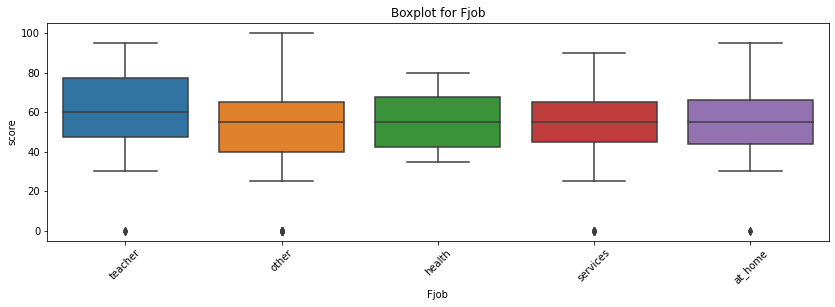

----------------------------------

Столбец reason
Распределение баллов по значениям признака:


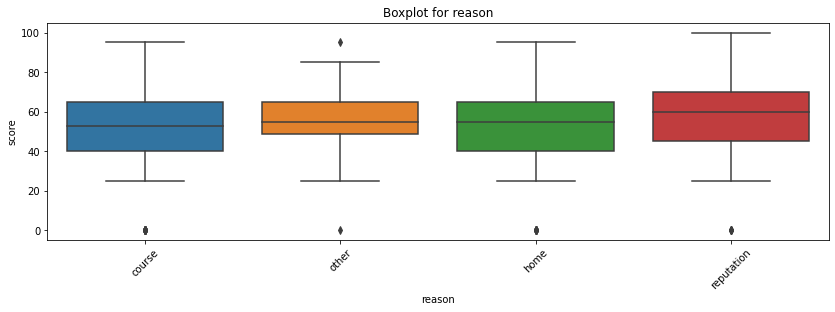

----------------------------------

Столбец guardian
Распределение баллов по значениям признака:


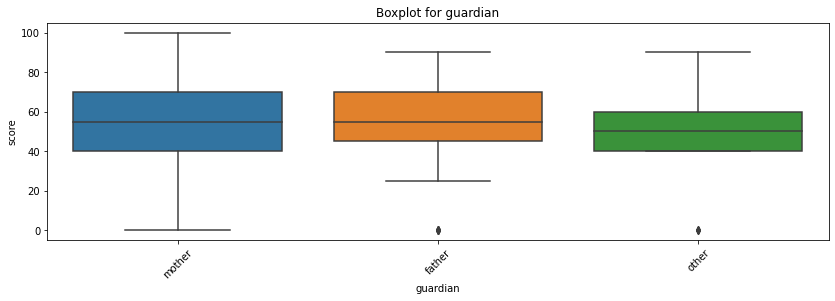

----------------------------------

Столбец schoolsup
Распределение баллов по значениям признака:


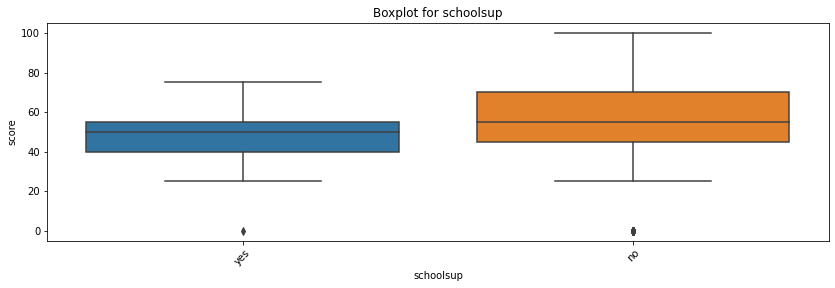

----------------------------------

Столбец famsup
Распределение баллов по значениям признака:


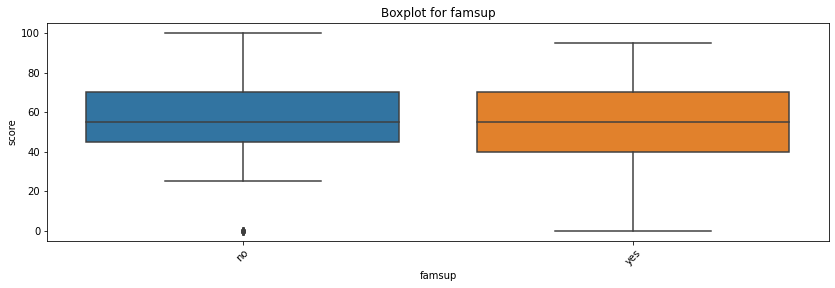

----------------------------------

Столбец paid
Распределение баллов по значениям признака:


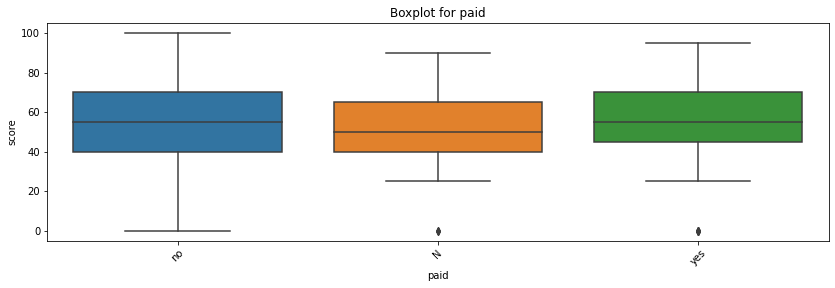

----------------------------------

Столбец activities
Распределение баллов по значениям признака:


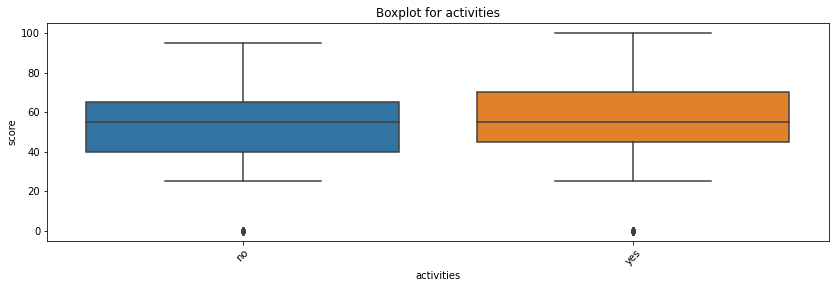

----------------------------------

Столбец nursery
Распределение баллов по значениям признака:


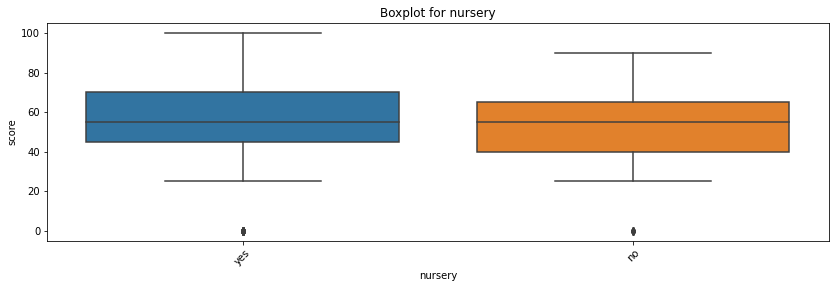

----------------------------------

Столбец higher
Распределение баллов по значениям признака:


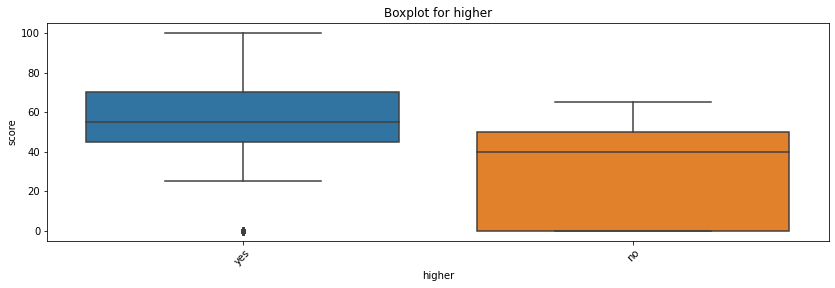

Найдены статистически значимые различия для колонки higher
----------------------------------

Столбец internet
Распределение баллов по значениям признака:


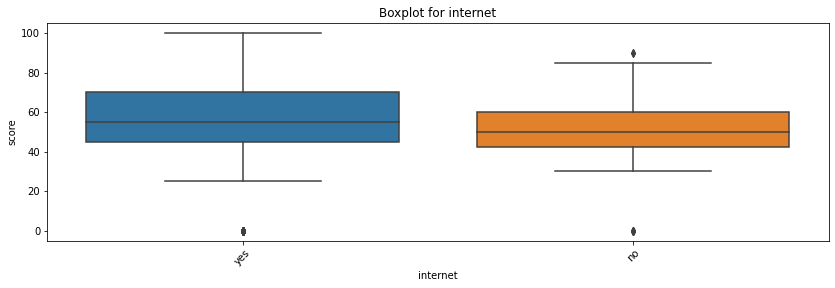

----------------------------------

Столбец romantic
Распределение баллов по значениям признака:


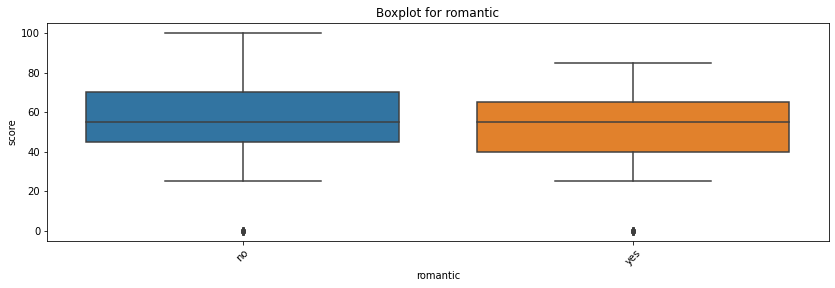

Найдены статистически значимые различия для колонки romantic
----------------------------------



In [154]:
nominative_columns_important = []
for column in students_raw.columns:
    nominative_analysis(column)

In [155]:
# Номинативные переменные, которые коррелируют с целевой
nominative_columns_important

['sex', 'address', 'Mjob', 'higher', 'romantic']

# Формирование датасета из значимых признаков для модели

In [156]:
dataset_columns = high_linear_correlation_columns + nominative_columns_important
dataset_columns

['failures',
 'Medu',
 'age',
 'Fedu',
 'studytime',
 'goout',
 'sex',
 'address',
 'Mjob',
 'higher',
 'romantic']

## Итоговый набор данных для построения модели

In [157]:
dataset = students_raw[dataset_columns]
scores = students_raw['score']

dataset.head()

,failures,Medu,age,Fedu,studytime,goout,sex,address,Mjob,higher,romantic
0,0.0,4.0,18,4.0,2.0,4.0,F,U,at_home,yes,no
1,0.0,1.0,17,1.0,2.0,3.0,F,U,at_home,yes,no
2,3.0,1.0,15,1.0,2.0,2.0,F,U,at_home,yes,no
3,0.0,4.0,15,2.0,3.0,2.0,F,U,health,yes,yes
4,0.0,3.0,16,3.0,2.0,2.0,F,U,other,yes,no


In [158]:
dataset.shape

(377, 11)

In [159]:
scores.shape

(377,)

In [160]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 394
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   failures   377 non-null    float64
 1   Medu       377 non-null    float64
 2   age        377 non-null    int64  
 3   Fedu       377 non-null    float64
 4   studytime  377 non-null    float64
 5   goout      377 non-null    float64
 6   sex        377 non-null    object 
 7   address    377 non-null    object 
 8   Mjob       377 non-null    object 
 9   higher     377 non-null    object 
 10  romantic   377 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 43.4+ KB


# Выводы

__В результате EDA для анализа влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:__

 - В данных достаточно мало пустых значений, только в столбцах Pstatus, famsup, paid было примерно по 10% пропусков.
 - Выбросы найдены только в столбцах с возрастом, образованием отца, семейными отношениями и количеством пропущенных занятий, то есть в 4х признаках из 29, что позволяет сделать вывод о том, что данные достаточно чистые.
 - Выбросы, обусловленные некачественным сбором данных, найдены в столбцах Fedu, famrel. В столбце absences выбросы, похоже, обусловлены как некачественным сбором данных (значения больше 200), так и экстремальными количествами пропусков (например, 53).
 - Состояние здоровья, пропуски, время до школы, отношения в семье, а также количество свободного времени после школы практически не коррелируют с успешностью на ЕГЭ.
 - Работа матери влияет на успешность на ЕГЭ, а работа отца - нет.
 - Для дальнейшего построения модели рекомендуется использовать параметры sex, address, Mjob, higher, romantic, age, Medu, Fedu, studytime, failures, goout.

# Подготовка данных для моделирования

In [161]:
dataset.head()

,failures,Medu,age,Fedu,studytime,goout,sex,address,Mjob,higher,romantic
0,0.0,4.0,18,4.0,2.0,4.0,F,U,at_home,yes,no
1,0.0,1.0,17,1.0,2.0,3.0,F,U,at_home,yes,no
2,3.0,1.0,15,1.0,2.0,2.0,F,U,at_home,yes,no
3,0.0,4.0,15,2.0,3.0,2.0,F,U,health,yes,yes
4,0.0,3.0,16,3.0,2.0,2.0,F,U,other,yes,no


In [162]:
encoder = preprocessing.OneHotEncoder()
data_encoded = encoder.fit_transform(dataset[['sex', 'address', 'Mjob', 'higher', 'romantic']]).toarray()
display(encoder.get_feature_names_out())

# one_hot_encoded_frame = pd.DataFrame.sparse.from_spmatrix(data_encoded, columns=encoder.get_feature_names_out())
one_hot_encoded_frame = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(), index=dataset.index)
display(one_hot_encoded_frame.head())

array(['sex_F', 'sex_M', 'address_R', 'address_U', 'Mjob_at_home',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'higher_no', 'higher_yes', 'romantic_no', 'romantic_yes'],
      dtype=object)

,sex_F,sex_M,address_R,address_U,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,higher_no,higher_yes,romantic_no,romantic_yes
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [163]:
one_hot_encoded_frame.shape

(377, 13)

In [164]:
dataset.shape

(377, 11)

In [165]:
dataset_preprocessed = pd.concat([dataset, one_hot_encoded_frame], axis=1)
dataset_preprocessed.head()

,failures,Medu,age,Fedu,studytime,goout,sex,address,Mjob,higher,romantic,sex_F,sex_M,address_R,address_U,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,higher_no,higher_yes,romantic_no,romantic_yes
0,0.0,4.0,18,4.0,2.0,4.0,F,U,at_home,yes,no,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,17,1.0,2.0,3.0,F,U,at_home,yes,no,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3.0,1.0,15,1.0,2.0,2.0,F,U,at_home,yes,no,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,4.0,15,2.0,3.0,2.0,F,U,health,yes,yes,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,3.0,16,3.0,2.0,2.0,F,U,other,yes,no,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [166]:
dataset_preprocessed.shape

(377, 24)

In [167]:
dataset_preprocessed = dataset_preprocessed.drop(['sex', 'address', 'Mjob', 'higher', 'romantic'], axis=1)
dataset_preprocessed.head()

,failures,Medu,age,Fedu,studytime,goout,sex_F,sex_M,address_R,address_U,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,higher_no,higher_yes,romantic_no,romantic_yes
0,0.0,4.0,18,4.0,2.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,17,1.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3.0,1.0,15,1.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,4.0,15,2.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,3.0,16,3.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [168]:
dataset_preprocessed.shape

(377, 19)

In [169]:
scores.shape

(377,)

# Моделирование

## Разделение данных на тренировочную и тестовую выборки

Таким образом, на вход моделей машинного обучения подаётся подготовленная нами<br>
таблица с различными характеристиками студентов в отдельных колонках (отдельные факторы).

In [222]:
# dataset_preprocessed - подготовленные нами табличные данные об учащихся
# scores - столбец с оценками учащихся за экзамен по математике
# Обязательно делим таблицу dataset_preprocessed и целевой столбец scores
# в соотношении 80%/20% на тренировочную и тестовую выборки.
# Модели машинного обучения "обучаются" на тренировочной выборке (80%),
# а ошибки этих моделей проверяются на тестовой выборке (20%).
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dataset_preprocessed, scores,
    test_size=0.2,
    random_state=42
)

In [223]:
display(X_train.shape)
display(y_train.shape)

display(X_test.shape)
display(y_test.shape)

(301, 19)

(301,)

(76, 19)

(76,)

### Базовая модель - Линейная регрессия

\begin{equation}
y_{predicted} = w_0 + \sum_{i=1}^m w_i \cdot X_i = w_0 + w_1 \cdot X_1 + w_2 \cdot X_2 + \ldots + w_m \cdot X_m\,,
\end{equation}

где $X_i$ - колонка с номером $i$ (назовём её фактором с номером $i$) из нашей очищенной выше и подготовленной таблицы данных об учащихся, $w_i$ - коэффициент, вес это колонки.

Воспользуемся готовым алгоритмом для нахождения коэффициентов линейной регрессии $w_i$ из <br>
программной библиотеки "scikit-learn" (https://scikit-learn.org/stable/):<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [224]:
# Создаём модель линейной регрессии.
model = linear_model.LinearRegression()

# "Обучаем" нашу модель линейной регрессии на тренировочной выборке учащихся.
model.fit(X_train, y_train)

# Предсказываем на тренировочной выборке оценки за экзамен.
y_train_predicted = model.predict(X_train)

# Предсказываем на тестовой выборке учащихся оценки за экзамен.
y_test_predicted = model.predict(X_test)

In [225]:
y_test_predicted[0:20]

array([52.08868467, 55.14452875, 48.33238398, 47.04371174, 61.9092164 ,
       45.05655289, 46.40861537, 52.16966177, 46.77371115, 43.08378715,
       43.09625877, 29.29754919, 61.92648859, 58.86167336, 55.68578694,
       49.06892993, 41.04397645, 61.92276234, 53.3429245 , 47.26944341])

In [226]:
y_test[0:20].to_numpy()

array([80., 50., 55.,  0., 75., 50., 65., 50., 35., 70., 65., 65., 60.,
       30., 50., 40., 25., 70., 75., 50.])

Вычисляем различные виды ошибок нашей модели на тренировочной выборке учащихся. 

In [227]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_train, y_train_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_train, y_train_predicted):.2f}</b></span>"))

Вычисляем различные виды ошибок нашей модели на тестовой выборке учащихся. 

In [228]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_test, y_test_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test, y_test_predicted):.2f}</b></span>"))

$w_0$ =

In [229]:
model.intercept_

56.06128219195331

Остальные коэффициенты $w_i$ =

In [230]:
model.coef_

array([-8.93801956,  3.06722742, -0.66380356, -1.22508655,  2.59123055,
       -1.84586712, -3.03627254,  3.03627254, -2.2809765 ,  2.2809765 ,
       -0.26665706,  5.24383225, -1.47105963,  1.51698584, -5.0231014 ,
       -3.18629002,  3.18629002,  1.77263089, -1.77263089])

### Стандартизация факторов

In [231]:
scaler = preprocessing.StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [232]:
model = linear_model.LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_predicted = model.predict(X_train_scaled)

y_test_predicted = model.predict(X_test_scaled)

In [233]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_test, y_test_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test, y_test_predicted):.2f}</b></span>"))

## Решающее дерево

In [234]:
model = tree.DecisionTreeRegressor(max_depth=20, random_state=42)
model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

In [235]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_train, y_train_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_train, y_train_predicted):.2f}</b></span>"))

In [236]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_test, y_test_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test, y_test_predicted):.2f}</b></span>"))

## Случайный лес деревьев (много параллельных слабых алгоритмов, решающих общую задачу)

In [237]:
model = ensemble.RandomForestRegressor(n_estimators=300, max_depth=10)
model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

In [238]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_train, y_train_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_train, y_train_predicted):.2f}</b></span>"))

In [239]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_test, y_test_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test, y_test_predicted):.2f}</b></span>"))

## Градиентный бустинг (создание последовательно композиции из алгоритмов деревьев, каждый из которых учитывает ошибки предыдущего)

In [240]:
model = ensemble.GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.01, max_depth=8, min_samples_leaf=5, random_state=42
)
model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

In [241]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_train, y_train_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_train, y_train_predicted):.2f}</b></span>"))

In [242]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_test, y_test_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test, y_test_predicted):.2f}</b></span>"))

## Полиномиальные признаки

In [243]:
p_features = preprocessing.PolynomialFeatures(degree=2)
p_features.fit(X_train_scaled)

X_train_poly = p_features.transform(X_train)
X_test_poly = p_features.transform(X_test)

model = linear_model.LinearRegression()
model.fit(X_train_poly, y_train)
y_train_predicted = model.predict(X_train_poly)
y_test_predicted = model.predict(X_test_poly)

In [244]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_train, y_train_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_train, y_train_predicted):.2f}</b></span>"))

In [245]:
display(HTML(f"<span style='font-size: 18pt'><b>Среднеквадратичная ошибка: {metrics.mean_squared_error(y_test, y_test_predicted):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Квадратный корень из среднеквадратичной ошибки: {np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)):.2f}</b></span>"))
display(HTML(f"<span style='font-size: 18pt'><b>Средняя абсолютная ошибка: {metrics.mean_absolute_error(y_test, y_test_predicted):.2f}</b></span>"))

**Предварительный вывод:** стандартная модель линейной регрессии LinearRegression (метод из sklearn на базе метода наименьших квадратов) подходит лучше из всех остальных опробованных.
Возможно стоит лучше изучить распределения признаков и преобразовать какие-то из них к распределению, близкому к нормальному. Также стоит увеличить размеры выборки.

## Переход от задачи регрессии к классификации

Вместо столбца с отметками за экзамен сделаем сами столбец с нулями и единицами,<br>
в котором единица (`True`) означает, что число баллов за экзамен больше или равен 60-ти, а<br>
ноль означает, что балл был меньше 60-ти (низкий балл, `False`).

То есть появляется два класса учащихся - те кто сдали экзамен и те, кто не сдали его.

In [246]:
scores.describe()

count    377.000000
mean      52.228117
std       22.911624
min        0.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

In [247]:
passed_scores = scores.apply(lambda score: 1 if score >= 60 else 0)

passed_scores.value_counts()

0    219
1    158
Name: score, dtype: int64

In [248]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dataset_preprocessed, passed_scores, test_size=0.2, stratify=passed_scores, random_state=42
)

# Логистическая регрессия

\begin{equation}
y(X) = \frac{1}{1 + \exp{\left( -z(X) \right)}}
\end{equation}

\begin{equation}
z(X) = \beta_0 + \sum_i{\beta_i \cdot X_i}
\end{equation}

In [249]:
model = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=0.5, random_state=42)
model.fit(X_train, y_train)

y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

In [250]:
y_test_predicted[0:20]

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0])

In [251]:
y_test[0:20].to_numpy()

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

Популярные базовые метрики качества классификации для случая двух классов:

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$$

Метрики на тренировочной выборке

In [252]:
display(HTML(f"Accuracy: {metrics.accuracy_score(y_train, y_train_predicted)}"))
display(HTML(f"Precision (точность): {metrics.precision_score(y_train, y_train_predicted)}"))
display(HTML(f"Recall (полнота): {metrics.recall_score(y_train, y_train_predicted)}"))
display(HTML(f"F1-мера: {metrics.f1_score(y_train, y_train_predicted)}"))

Метрики на тестовой выборке

In [253]:
display(HTML(f"Accuracy: {metrics.accuracy_score(y_test, y_test_predicted)}"))
display(HTML(f"Precision (точность): {metrics.precision_score(y_test, y_test_predicted)}"))
display(HTML(f"Recall (полнота): {metrics.recall_score(y_test, y_test_predicted)}"))
display(HTML(f"F1-мера: {metrics.f1_score(y_test, y_test_predicted)}"))

### Матрица ошибок

In [254]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[34, 10],
       [17, 15]])

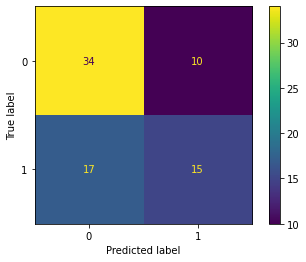

In [255]:
metrics.plot_confusion_matrix(model, X_test, y_test)